# Integrate Macaque, human, and mouse with Seurat - Main Figure 3

### Must Run first: Load packages

In [1]:
## conda activate r4
## packages for data table processing

#IRkernel::installspec()

## main Seurat package snRNA-seq packages

### to find anchor information 
#https://satijalab.org/seurat/reference/anchorset-class

library(Seurat)
library(SeuratDisk)
library(future)

library(here)
library(tidyverse)
library(ggpubr)

library(caret)
library(cluster)

#install.packages('hash')
library(hash)

ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)

#######################################################
# 0) Seurat uses the future package for parallelization
## set to be parallel over 28 cores
plan("multicore", workers = 28)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

Registered S3 method overwritten by 'spatstat':
  method     from
  print.boxx cli 

Warning message:
“package ‘SeuratDisk’ was built under R version 4.0.3”
Registered S3 methods overwritten by 'SeuratObject':
  method                     from  
  $.JackStrawData            Seurat
  $.Seurat                   Seurat
  $.SeuratCommand            Seurat
  $<-.Seurat                 Seurat
  [.Assay                    Seurat
  [.DimReduc                 Seurat
  [.Seurat                   Seurat
  [.SeuratCommand            Seurat
  [.SpatialImage             Seurat
  [[.Assay                   Seurat
  [[.DimReduc                Seurat
  [[.Seurat                  Seurat
  levels<-.Seurat            Seurat
  .DollarNames.JackStrawData Seurat
  .DollarNames.Seurat        Seurat
  .DollarNames.SeuratCommand Seurat
  as.list.SeuratCommand      Seurat
  as.logical.JackStrawData   Seurat
  dim.Assay                  Seurat
  dim.DimReduc               Seurat
  dim.Neighbor               Seura

ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’


# load data, pre-process

In [2]:
# load human and macaque rna dataset
macaque_rna = LoadH5Seurat("/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/macaque_integrated_neuronsv3.h5seurat",assay = "RNA")
macaque_rna$nCount_RNA = macaque_rna$nUMI # equivalent data
macaque_rna$nFeature_RNA = macaque_rna$nGene # equivalent data

human_rna = readRDS('/projects/pfenninggroup/singleCell/HumanMacaqueMouse_DorsalHorn_snRNA-Seq/data/tidy_data/Levine_Human_dorsal_horn_celltypes/rdas/human_neurons.rds')

mouse_rna = LoadH5Seurat('/home/bnphan/projects/2022_DH_Russ_cell_types/data/tidy_data/rdas/Russ_et_al_dorsal_horn_neurons.h5seurat')
mouse_rna = mouse_rna[, mouse_rna$dataset == 'Sathyamurthy']
Idents(object = mouse_rna) <- "final_cluster_assignment"
DefaultAssay(mouse_rna) = 'RNA'

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction pca

Adding cell embeddings for pca

Adding miscellaneous information for pca



ERROR: Error in `[[<-`(`*tmp*`, reduc, value = new("DimReduc", cell.embeddings = structure(c(-14.916187286377, : [[<- defined for objects of type "S4" only for subclasses of environment


In [ ]:
### mouse genes to human genes
convertHumanGeneList <- function(x){
  file = '/home/bnphan/resources/genomes/GRCh38.p13/ENSEMBL_GRCh38.p13_genes_to_Orthologous_mouse_genes.tsv'
  orthologs = read_tsv(file, show_col_types = FALSE) %>% 
    rename_with(make.names) %>% 
    dplyr::filter(Mouse.homology.type== 'ortholog_one2one') %>% 
    dplyr::filter(Mouse.gene.name %in% x) %>% 
    dplyr::select(Mouse.gene.name, Gene.name)
  
  # Print the first 6 genes found to the screen
  print(head(orthologs))
  return(orthologs)
}
# RenameGenesSeurat from https://github.com/satijalab/seurat/issues/1049
RenameGenesSeurat <- function(obj, newnames) {
  # Replace gene names in different slots of a Seurat object. Run this before integration.
  # It only changes obj@assays$RNA@counts, @data and @scale.data.
  print("Run this before integration. It only changes obj@assays$RNA@counts, @data and @scale.data.")
  RNA <- obj@assays$RNA

  if (nrow(RNA) == length(newnames)) {
    if (length(RNA@counts)) RNA@counts@Dimnames[[1]]            <- newnames
    if (length(RNA@data)) RNA@data@Dimnames[[1]]                <- newnames
    if (length(RNA@scale.data)) RNA@scale.data@Dimnames[[1]]    <- newnames
  } else {"Unequal gene sets: nrow(RNA) != nrow(newnames)"}
  obj@assays$RNA <- RNA
  return(obj)
}

## switch out human gene names w/ orthologous mouse gene names, based on ENSEMBL
MmtoHg = convertHumanGeneList(rownames(mouse_rna)) %>% deframe()
mouse_rna = mouse_rna[names(MmtoHg[!is.na(MmtoHg)]), ]
mouse_rna = RenameGenesSeurat(mouse_rna, newnames = MmtoHg[rownames(mouse_rna)])
mouse_rna = mouse_rna[!is.na(rownames(mouse_rna)), ]
head(rownames(mouse_rna))

In [4]:
## load human and macaque RNA and subset to dorsal horn
human_cell_types = unique(human_rna$final_ann)
human_dh_types = human_cell_types[grep('Dorsal', human_cell_types)]

macaque_cell_types = unique(macaque_rna$cluster_type)
GLUTs = macaque_cell_types[grep('GLUT', macaque_cell_types)]
GABAs = macaque_cell_types[grep('GABA', macaque_cell_types)]
macaque_dh_types = c(GLUTs, GABAs)

Idents(object = human_rna) <- "final_ann"
human_rna_dh = subset(x = human_rna, idents = human_dh_types)
rm(human_rna)

Idents(object = macaque_rna) <- "cluster_type"
macaque_rna_dh = subset(x = macaque_rna, idents = macaque_dh_types)
rm(macaque_rna)

In [5]:
table(macaque_rna_dh$cluster_type)


  GLUT1   GLUT2   GLUT3   GLUT4   GLUT5   GLUT6   GLUT7   GLUT8   GLUT9  GLUT10 
    142     222     152      49     105     123     124      76      98      62 
 GLUT11   GABA1 GABA2_1 GABA2_2   GABA3 GABA4_1 GABA4_2   GABA5  midVen 
     89     109      65      71      74      91     100     202       0 

In [6]:
GetAssay(macaque_rna_dh)[]

  [[ suppressing 32 column names ‘1’, ‘2’, ‘4’ ... ]]

  [[ suppressing 32 column names ‘1’, ‘2’, ‘4’ ... ]]

  [[ suppressing 32 column names ‘1’, ‘2’, ‘4’ ... ]]



54894 x 1954 sparse Matrix of class "dgCMatrix"
                                                                                  
WASH7P       .         .         .         .         .         .         .        
MIR6859-1    .         .         .         .         .         .         .        
MIR1302-2HG  .         .         .         .         .         .         .        
MIR1302-2    .         .         .         .         .         .         .        
FAM138A      .         .         .         .         .         .         .        
OR4G4P       .         .         .         .         .         .         .        
OR4G11P      .         .         .         .         .         .         .        
OR4F5        .         .         .         .         .         .         .        
CICP27       .         .         .         .         .         .         .        
AL627309.2   .         .         .         .         .         .         .        
AL627309.5   .         .         .     

In [7]:
# normalize and identify variable features for each dataset independently

#macaque_rna_dh <- NormalizeData(macaque_rna_dh)
macaque_rna_dh <- FindVariableFeatures(macaque_rna_dh, selection.method = "vst", nfeatures = 2000)
macaque_rna_dh <- ScaleData(macaque_rna_dh)

#human_rna_dh <- NormalizeData(human_rna_dh)
human_rna_dh <- FindVariableFeatures(human_rna_dh, selection.method = "vst", nfeatures = 2000)
human_rna_dh <- ScaleData(human_rna_dh)

#mouse_rna <- NormalizeData(mouse_rna)
mouse_rna <- FindVariableFeatures(mouse_rna, selection.method = "vst", nfeatures = 2000)
mouse_rna <- ScaleData(mouse_rna)

mouse_rna <- RunPCA(mouse_rna, npcs = 30, verbose = FALSE)
mouse_rna <- RunUMAP(mouse_rna, reduction = "pca", dims = 1:30)

Centering and scaling data matrix

Centering and scaling data matrix

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:11:12 UMAP embedding parameters a = 0.9922 b = 1.112

15:11:12 Read 3868 rows and found 30 numeric columns

15:11:12 Using Annoy for neighbor search, n_neighbors = 30

15:11:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:11:13 Writing NN index file to temp file /tmp/Rtmp1T7YTN/file1383f66d4180f

15:11:13 Searching Annoy index using 28 threads, search_k = 3000

15:11:14 Annoy 

# Simultaneous Integration of all three datasets followed by transfer labeling

In [8]:
## for integration
human_rna_dh <- SCTransform(human_rna_dh)
macaque_rna_dh <- SCTransform(macaque_rna_dh)
mouse_rna <- SCTransform(mouse_rna)

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17201 by 1102

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1102 cells



  |======================================================================| 100%


Found 66 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17201 genes



  |======================================================================| 100%


Computing corrected count matrix for 17201 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 42.38551 secs

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 23924 by 1954

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 1954 cells



  |======================================================================| 100%


Found 109 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 23924 genes



  |======================================================================| 100%


Computing corrected count matrix for 23924 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.051668 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 12572 by 3868

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3868 cells



  |======================================================================| 100%


Found 48 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 12572 genes



  |======================================================================| 100%


Computing corrected count matrix for 12572 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.658213 mins

Determine variable features

Place corrected count matrix in counts slot

Centering data matrix

Set default assay to SCT



In [9]:
### Try to integrate all three datasets at the same time instead of sequentially
###

features <- SelectIntegrationFeatures(  object.list = list(human_rna_dh, macaque_rna_dh, mouse_rna)  )

## Find anchors and do integration
mac_human_mouse.anchors <- FindIntegrationAnchors(object.list = list(human_rna_dh, macaque_rna_dh, mouse_rna), anchor.features = features)
mac_human_mouse.combined <- IntegrateData(anchorset = mac_human_mouse.anchors,normalization.method = "SCT")
DefaultAssay(mac_human_mouse.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
mac_human_mouse.combined <- ScaleData(mac_human_mouse.combined, verbose = FALSE)
mac_human_mouse.combined <- RunPCA(mac_human_mouse.combined, npcs = 30, verbose = FALSE)
mac_human_mouse.combined <- RunUMAP(mac_human_mouse.combined, reduction = "pca", dims = 1:30, return.model = TRUE)
mac_human_mouse.combined <- FindNeighbors(mac_human_mouse.combined, reduction = "pca", dims = 1:30)
mac_human_mouse.combined <- FindClusters(mac_human_mouse.combined, resolution = 0.5)

mac_human_mouse.combined$species = ifelse(is.na(mac_human_mouse.combined$cluster_type), 'notmacaque', 'macaque')
mac_human_mouse.combined$species = ifelse(is.na(mac_human_mouse.combined$final_cluster_assignment), mac_human_mouse.combined$species, 'mouse')
mac_human_mouse.combined$species = ifelse(is.na(mac_human_mouse.combined$final_ann), mac_human_mouse.combined$species, 'human')

mac_human_mouse.combined$integrated_celltype = ifelse(is.na(mac_human_mouse.combined$cluster_type), '', mac_human_mouse.combined$cluster_type)
mac_human_mouse.combined$integrated_celltype = ifelse(is.na(mac_human_mouse.combined$final_cluster_assignment), mac_human_mouse.combined$integrated_celltype, mac_human_mouse.combined$final_cluster_assignment)
mac_human_mouse.combined$integrated_celltype = ifelse(is.na(mac_human_mouse.combined$final_ann), mac_human_mouse.combined$integrated_celltype, mac_human_mouse.combined$final_ann)


Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3065 anchors

Filtering anchors

	Retained 2524 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3634 anchors

Filtering anchors

	Retained 1859 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 5238 anchors

Filtering anchors

	Retained 2652 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 1 into 3

Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”
Extracting anchors for merged samples

Warning message:
“Attempting to merge an SCTAssay with another Assay type 
Converting all to standard Assay objects.”
Finding integration vectors

Finding integration vector weights

Integrating d

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6924
Number of edges: 285596

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9393
Number of communities: 20
Elapsed time: 0 seconds


In [10]:
# https://www.biostars.org/p/9559043/ subsetting
### Try to transfer labels on the integrated dataset
human_subset_integrated <- mac_human_mouse.combined
human_subset_integrated <- subset(x = mac_human_mouse.combined, subset = final_ann %in% unique(human_rna_dh$final_ann))
macaque_subset_integrated <- mac_human_mouse.combined
macaque_subset_integrated = subset(x = mac_human_mouse.combined, subset = cluster_type %in% as.character(unique(macaque_rna_dh$cluster_type)))
mouse_subset_integrated <- mac_human_mouse.combined
mouse_subset_integrated = subset(x = mac_human_mouse.combined, subset = final_cluster_assignment %in% unique(mouse_rna$final_cluster_assignment))

human_to_macaque_transfer_anchors = FindTransferAnchors(reference = macaque_subset_integrated, query = human_subset_integrated, dims = 1:30)
human_to_macaque_predictions <- TransferData(anchorset = human_to_macaque_transfer_anchors, refdata = macaque_subset_integrated$cluster_type, dims = 1:30)
human_subset_integrated <- AddMetaData(object = human_subset_integrated, metadata = human_to_macaque_predictions)

### Now map mouse to macaque
mouse_to_macaque_transfer_anchors = FindTransferAnchors(reference = macaque_subset_integrated, query = mouse_subset_integrated, dims = 1:30)
mouse_to_macaque_predictions <- TransferData(anchorset = mouse_to_macaque_transfer_anchors, refdata = macaque_subset_integrated$cluster_type, dims = 1:30)
mouse_subset_integrated <- AddMetaData(object = mouse_subset_integrated, metadata = mouse_to_macaque_predictions)

#### for mouse/human comparison
mouse_to_human_transfer_anchors = FindTransferAnchors(reference = human_subset_integrated, query = mouse_subset_integrated, dims = 1:30)
mouse_to_human_predictions <- TransferData(anchorset = mouse_to_human_transfer_anchors, refdata = human_subset_integrated$final_ann, dims = 1:30)
mouse_human_names <- mouse_subset_integrated
mouse_human_names <- AddMetaData(object = mouse_subset_integrated, metadata = mouse_to_human_predictions)

Warning message in ValidateParams_FindTransferAnchors(reference = reference, query = query, :
“Both reference and query assays have been processed with SCTransform.Setting normalization.method = 'SCT' and continuing.”
Normalizing query using reference SCT model

Performing PCA on the provided reference using 1601 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 1609 anchors

Filtering anchors

	Retained 1287 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels

Warning message in ValidateParams_FindTransferAnchors(reference = reference, query = query, :
“Both reference and query assays have been processed with SCTransform.Setting normalization.method = 'SCT' and continuing.”
Normalizing query using reference SCT model

Performing PCA on the provided reference using 1601 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 2951 anchors

Filtering anchors

	

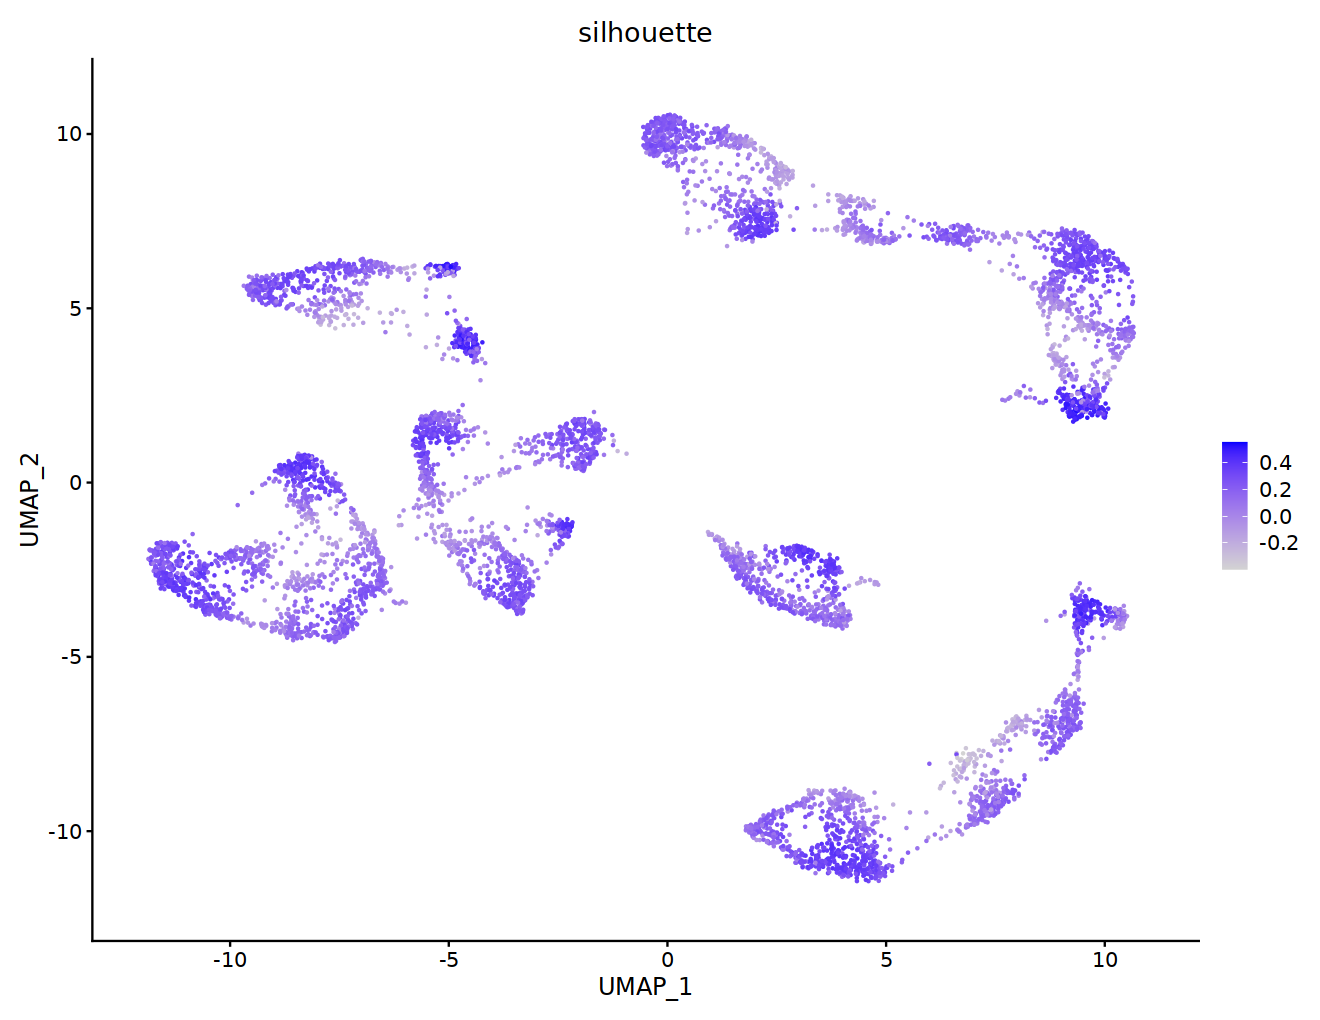

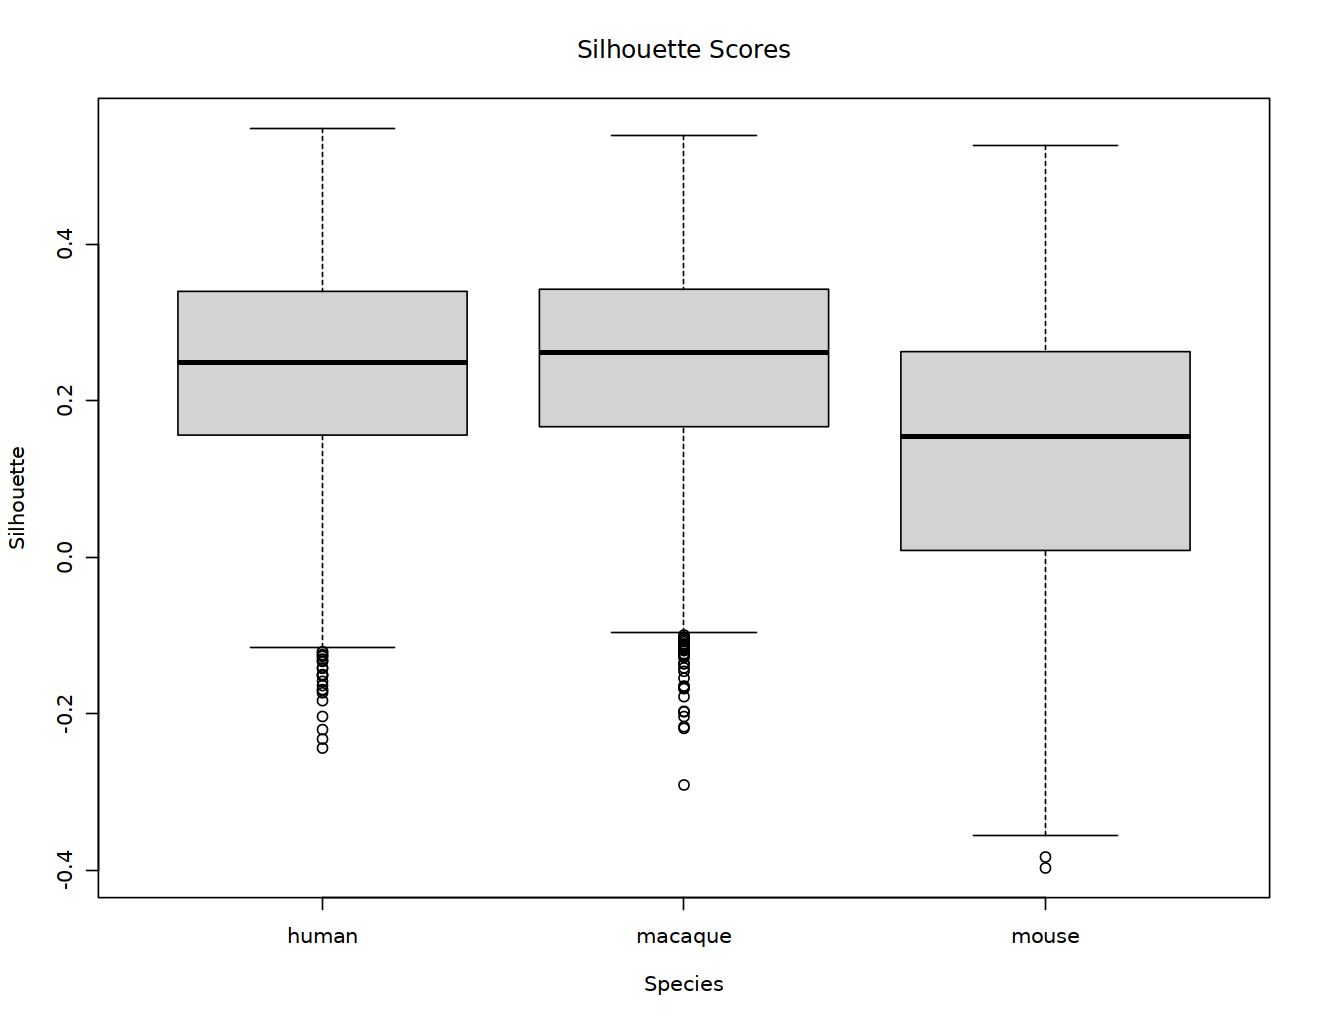

In [12]:
### silhouette scores
### based on https://github.com/satijalab/Integration2019/blob/master/analysis_code/integration/integration_metrics.R#L36
reduction <- "pca"
dims <- 1:30

dist.matrix <- dist(x = Embeddings(object = mac_human_mouse.combined[["pca"]])[, dims])
clusters <- mac_human_mouse.combined$seurat_clusters

sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
mac_human_mouse.combined$silhouette <- sil[, 3]

FeaturePlot(mac_human_mouse.combined, features = "silhouette")

boxplot(silhouette~species,data=mac_human_mouse.combined[[]], main="Silhouette Scores",
   xlab="Species", ylab="Silhouette")

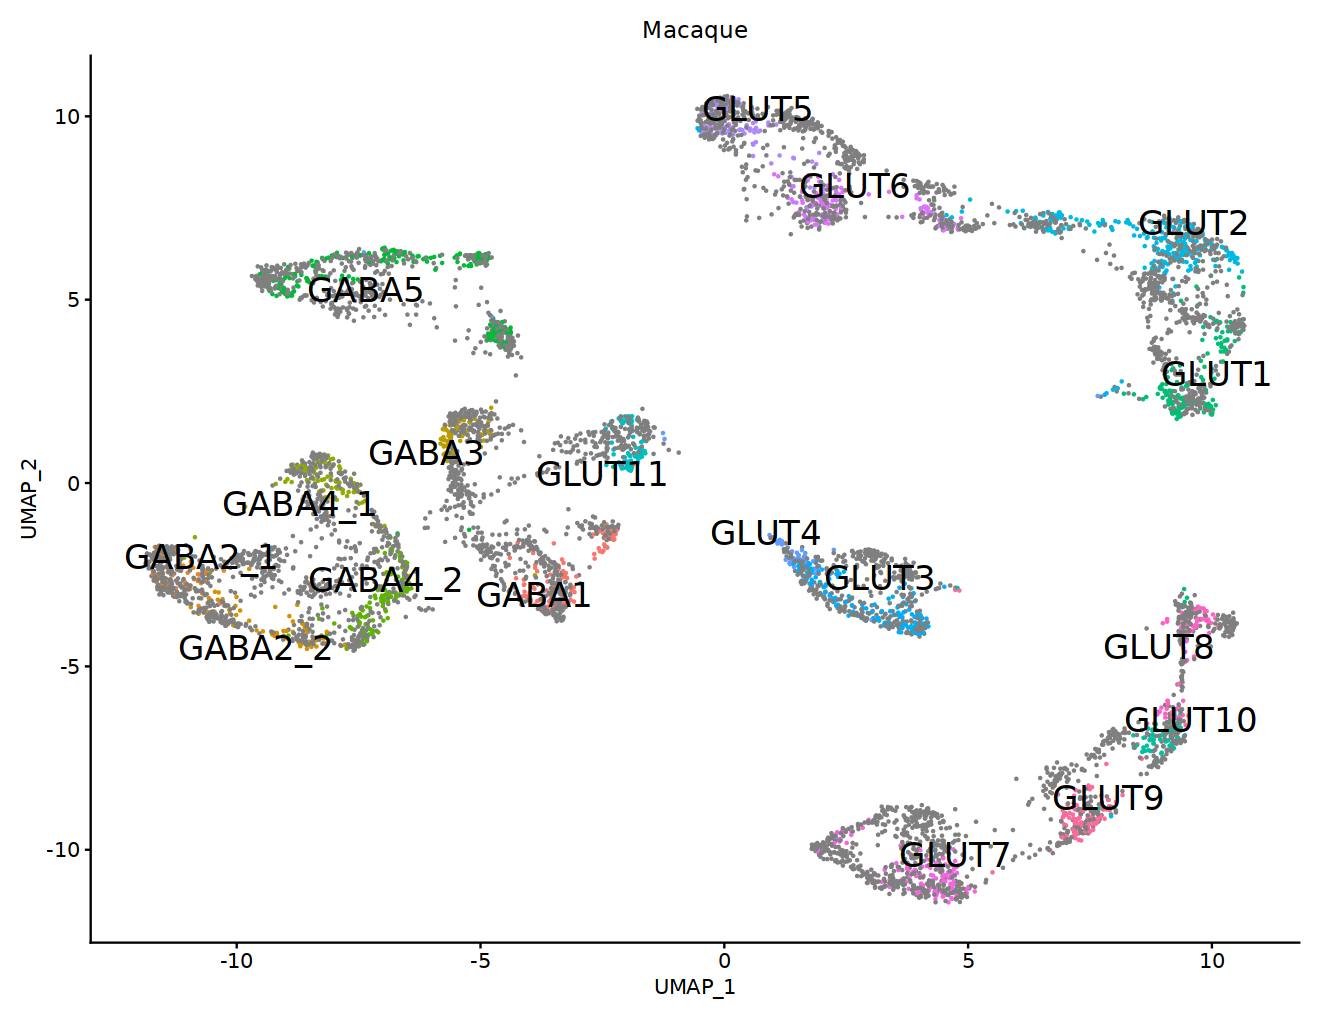

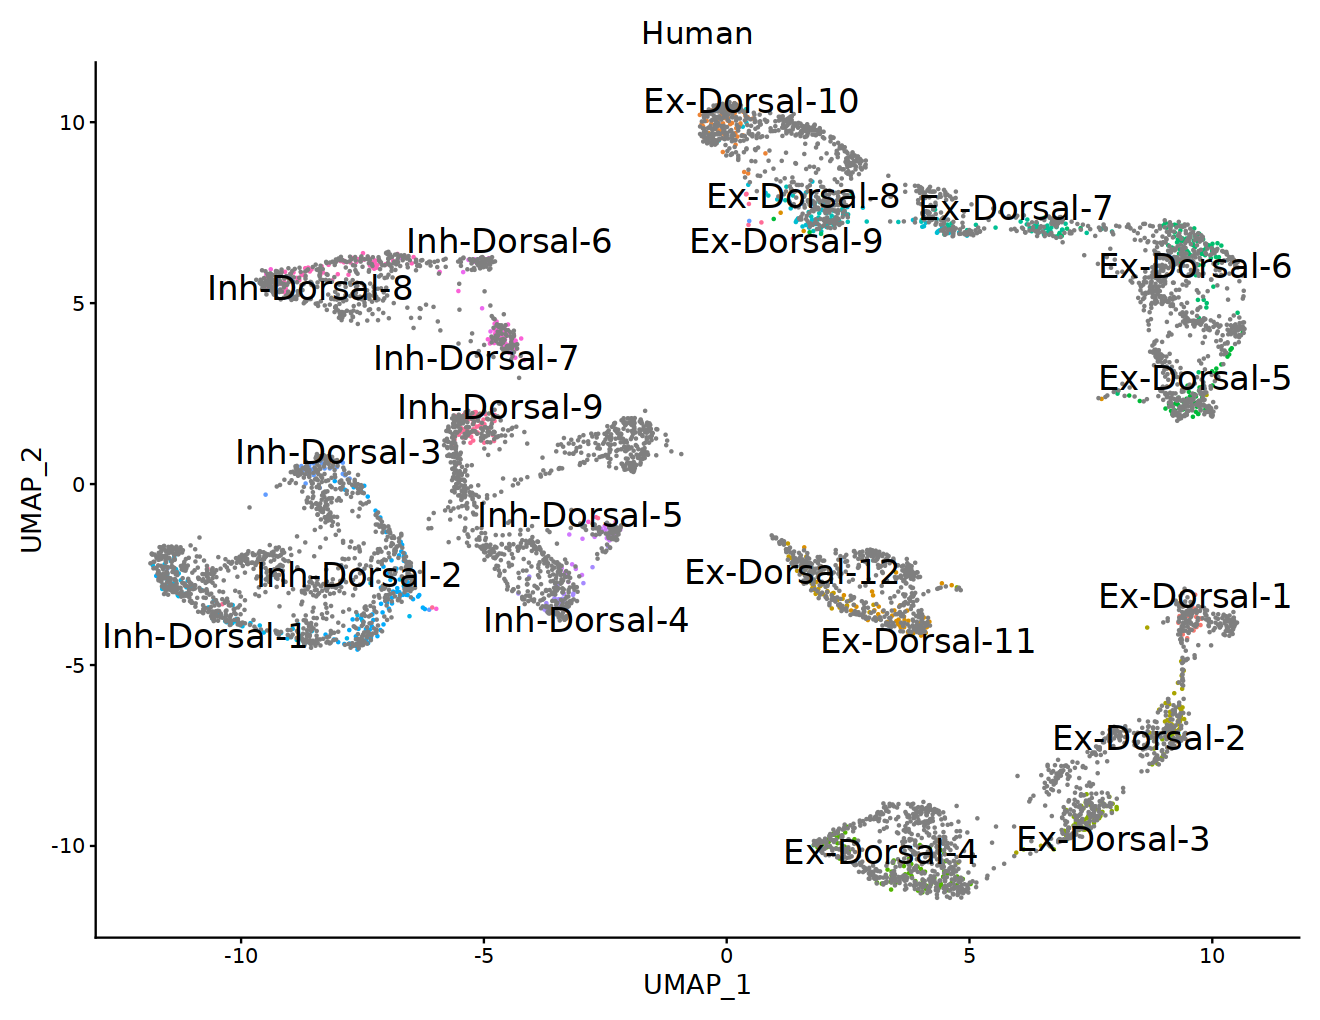

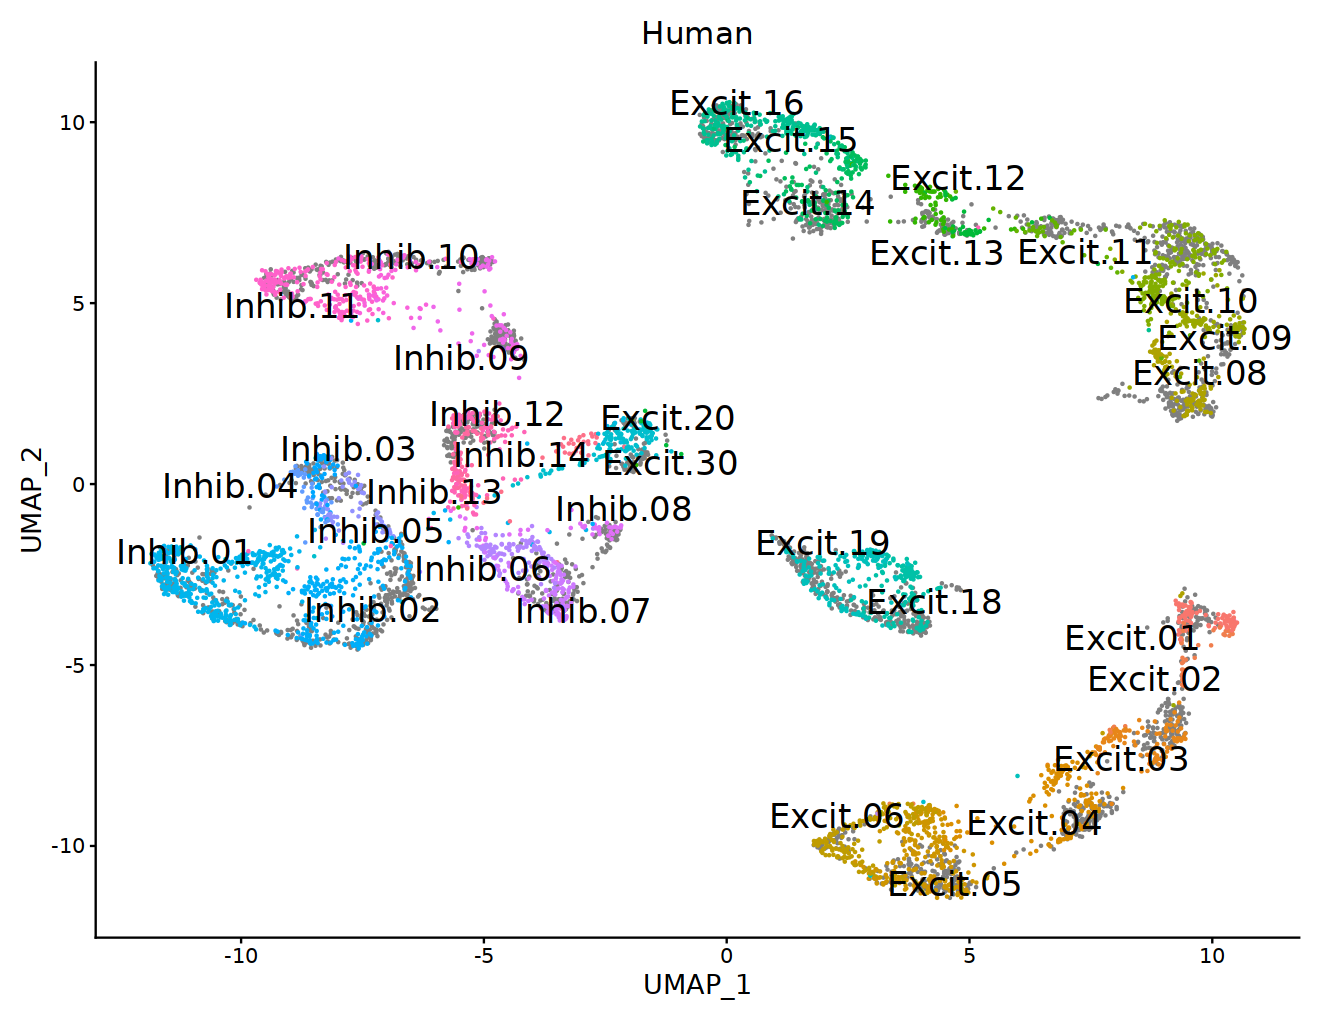

In [11]:
save_integration_figs = FALSE

p1 <- DimPlot(mac_human_mouse.combined, reduction = "umap", 
              group.by = "cluster_type", label = TRUE, 
              label.size = 7, repel = TRUE) + theme(text = element_text(size = 12), legend.position = "none") + labs(title="Macaque")

if (save_integration_figs){
tiff(here(paste0("figures/exploratory/arokiaraj_paper/macaque_integrated_",Sys.Date(),".tiff")), units="in", width=4, height=4, res=300)
# insert ggplot code
print(p1)
dev.off()
}
print(p1)


#### human
p1 <- DimPlot(mac_human_mouse.combined, reduction = "umap", 
              group.by = "final_ann", label = TRUE, 
              label.size = 7, repel = TRUE)+ theme(text = element_text(size = 16), legend.position = "none") + labs(title="Human")

if (save_integration_figs){
tiff(here(paste0("figures/exploratory/arokiaraj_paper/human_integrated_",Sys.Date(),".tiff")), units="in", width=4, height=4, res=300)
# insert ggplot code
print(p1)
dev.off()
}
print(p1)


#### mouse
p1 <- DimPlot(mac_human_mouse.combined, reduction = "umap", 
              group.by = "final_cluster_assignment", label = TRUE, 
              label.size = 7, repel = TRUE)+ theme(text = element_text(size = 16), legend.position = "none") + labs(title="Human")

if (save_integration_figs){
tiff(here(paste0("figures/exploratory/arokiaraj_paper/mouse_integrated_",Sys.Date(),".tiff")), units="in", width=4, height=4, res=300)
# insert ggplot code
print(p1)
dev.off()
}
print(p1)

png 
  2

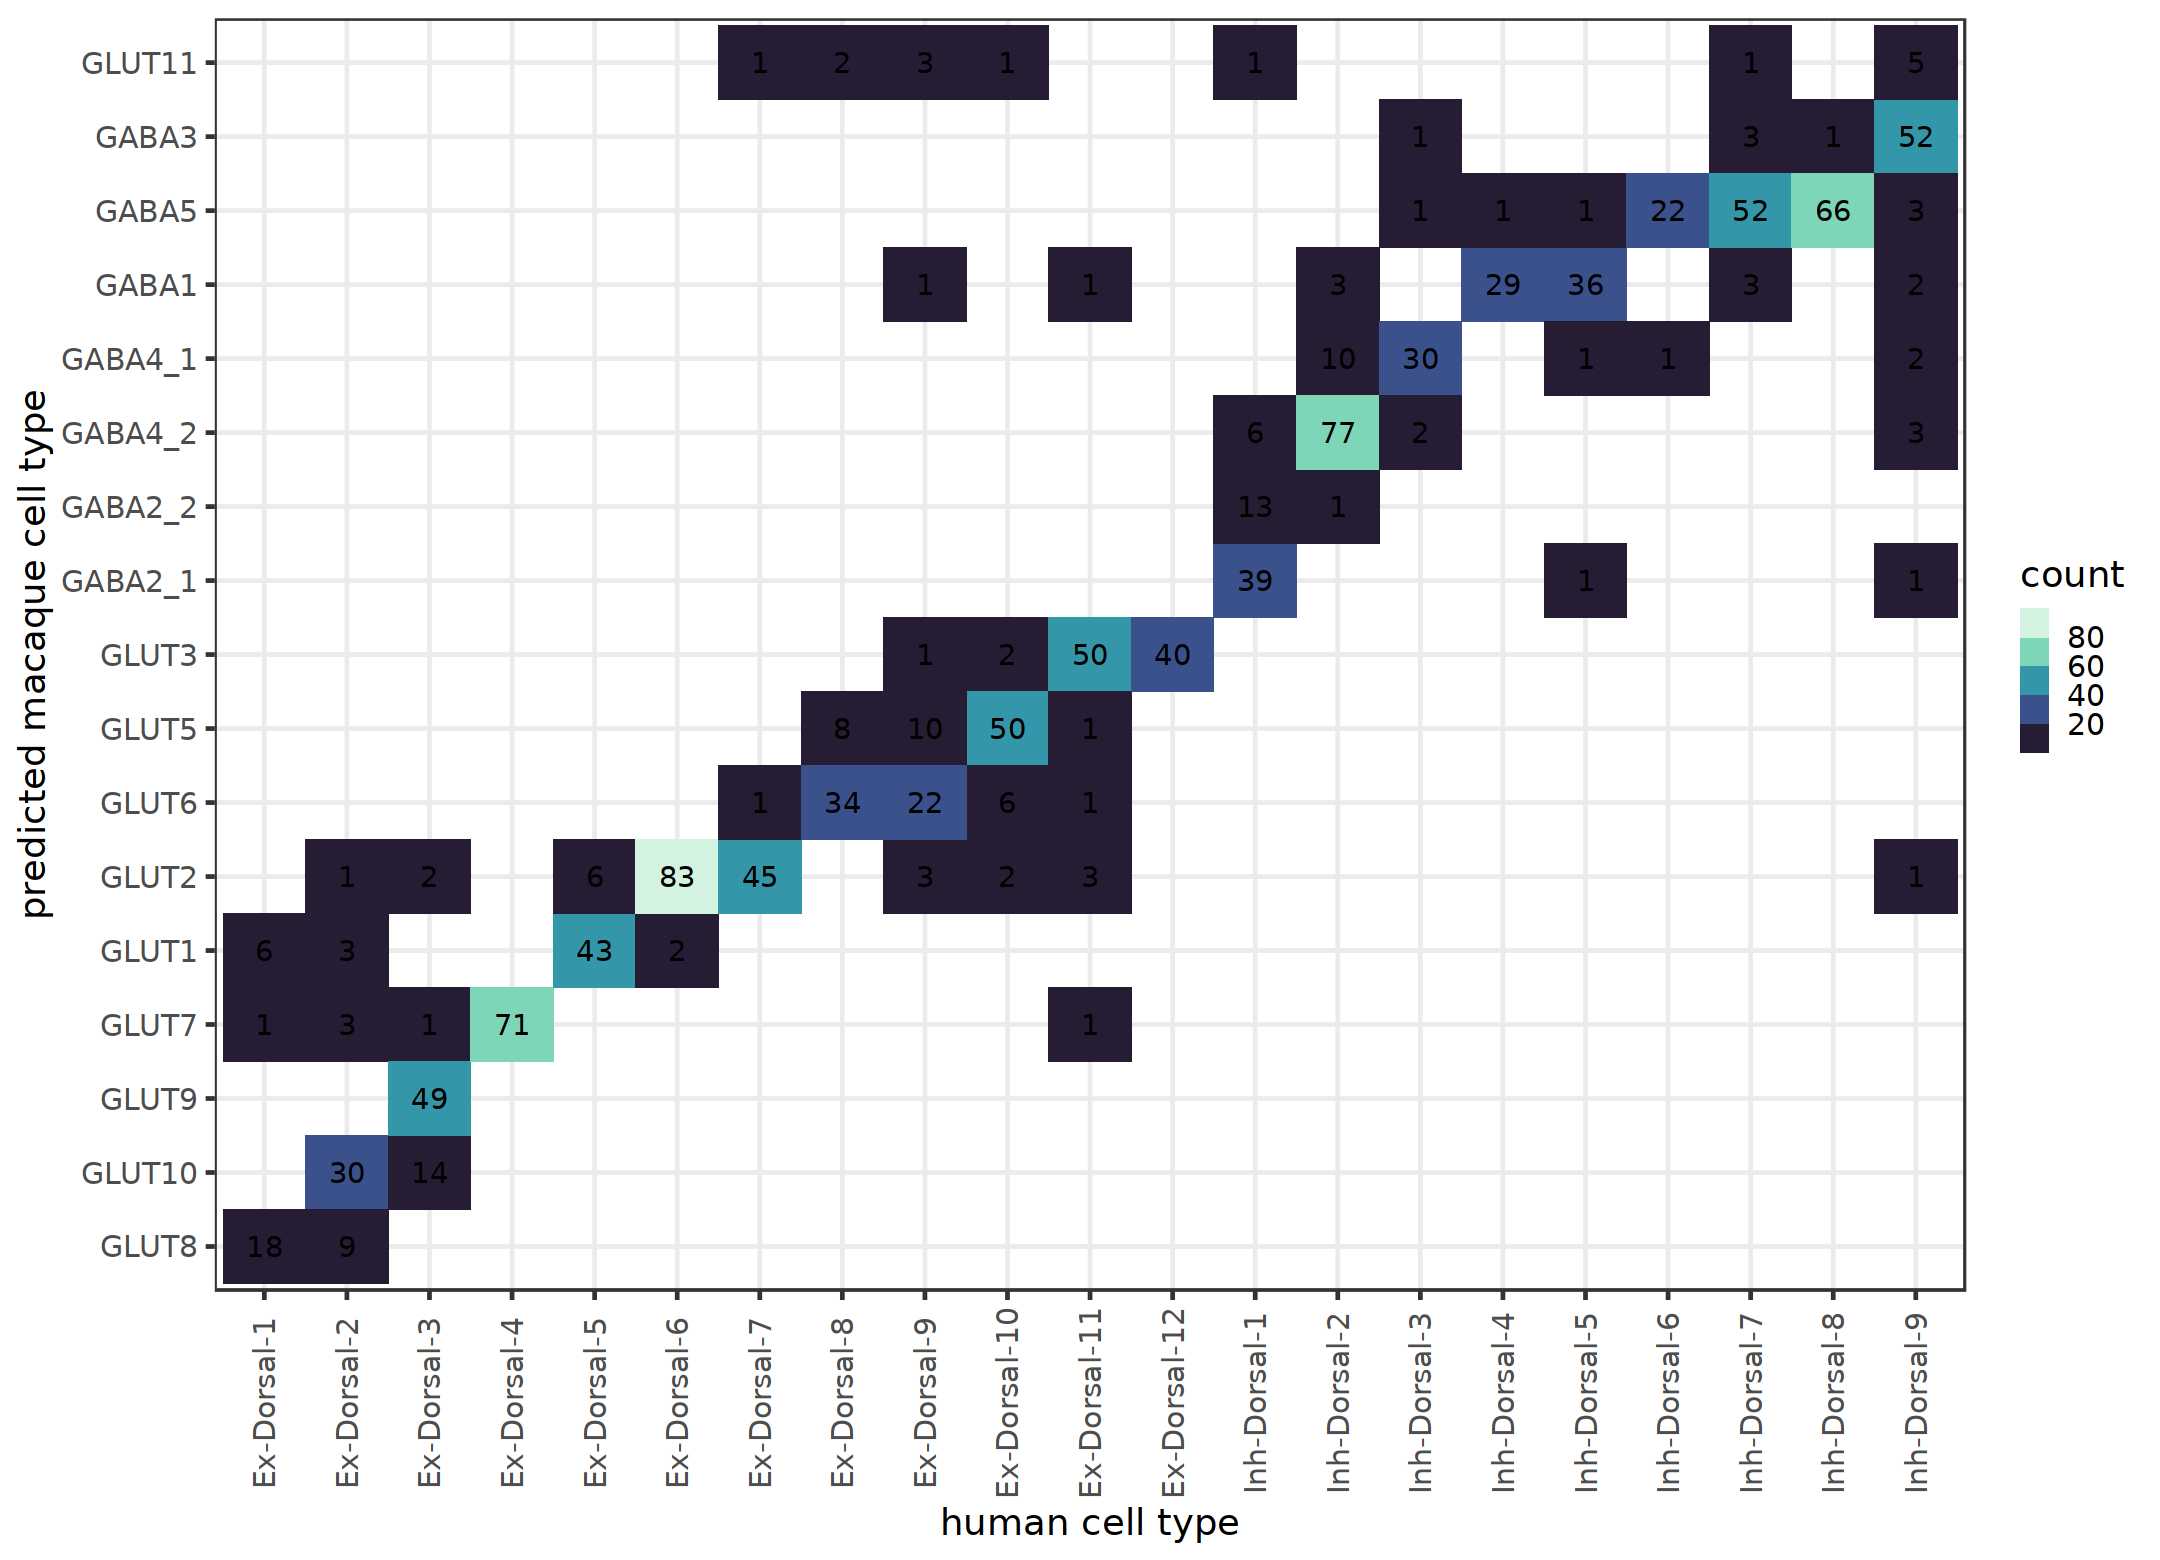

In [24]:
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=13)

human_ordered_types = c('Ex-Dorsal-1','Ex-Dorsal-2','Ex-Dorsal-3','Ex-Dorsal-4','Ex-Dorsal-5',
 'Ex-Dorsal-6','Ex-Dorsal-7','Ex-Dorsal-8','Ex-Dorsal-9','Ex-Dorsal-10',
 'Ex-Dorsal-11','Ex-Dorsal-12',
 'Inh-Dorsal-1','Inh-Dorsal-2','Inh-Dorsal-3','Inh-Dorsal-4','Inh-Dorsal-5',
 'Inh-Dorsal-6','Inh-Dorsal-7','Inh-Dorsal-8','Inh-Dorsal-9')
macaque_ordered_types = c('GLUT8','GLUT10','GLUT9',
'GLUT7','GLUT1','GLUT2','GLUT6','GLUT5','GLUT3','GABA2_1','GABA2_2','GABA4_2','GABA4_1',
                         'GABA1','GABA5','GABA3','GLUT4','GLUT11')


## Try a confusion matrix
seurat_object_species1 <- human_subset_integrated
seurat_object_species1[[]] %>% 
count(final_ann, predicted.id) %>% 
group_by(final_ann) %>%
mutate(count = n) %>% 
ungroup() %>% 
ggplot(aes(x = factor(final_ann, human_ordered_types), y = factor(predicted.id,macaque_ordered_types ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 22) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
scale_fill_viridis_b(option = 'mako') +
geom_text(aes(label =count), size = 6) +
scale_color_manual(values = c("black", "white")) + guides(color = "none") +
xlab("human cell type") + ylab("predicted macaque cell type")



### different dimension to save
tiff(here(paste0("figures/exploratory/arokiaraj_paper/human_integration_labels_",Sys.Date(),".tiff")), units="in", width=7, height=8, res=300)

## Try a confusion matrix
seurat_object_species1 <- human_subset_integrated
seurat_object_species1[[]] %>% 
count(final_ann, predicted.id) %>% 
group_by(final_ann) %>%
mutate(count = n) %>% 
ungroup() %>% 
ggplot(aes(x = factor(final_ann, human_ordered_types), y = factor(predicted.id,macaque_ordered_types ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 14) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
scale_fill_viridis_b(option = 'mako') +
geom_text(aes(label =count), size = 4) +
scale_color_manual(values = c("black", "white")) + guides(color = "none") +
xlab("human cell type") + ylab("predicted macaque cell type")

dev.off()

png 
  2

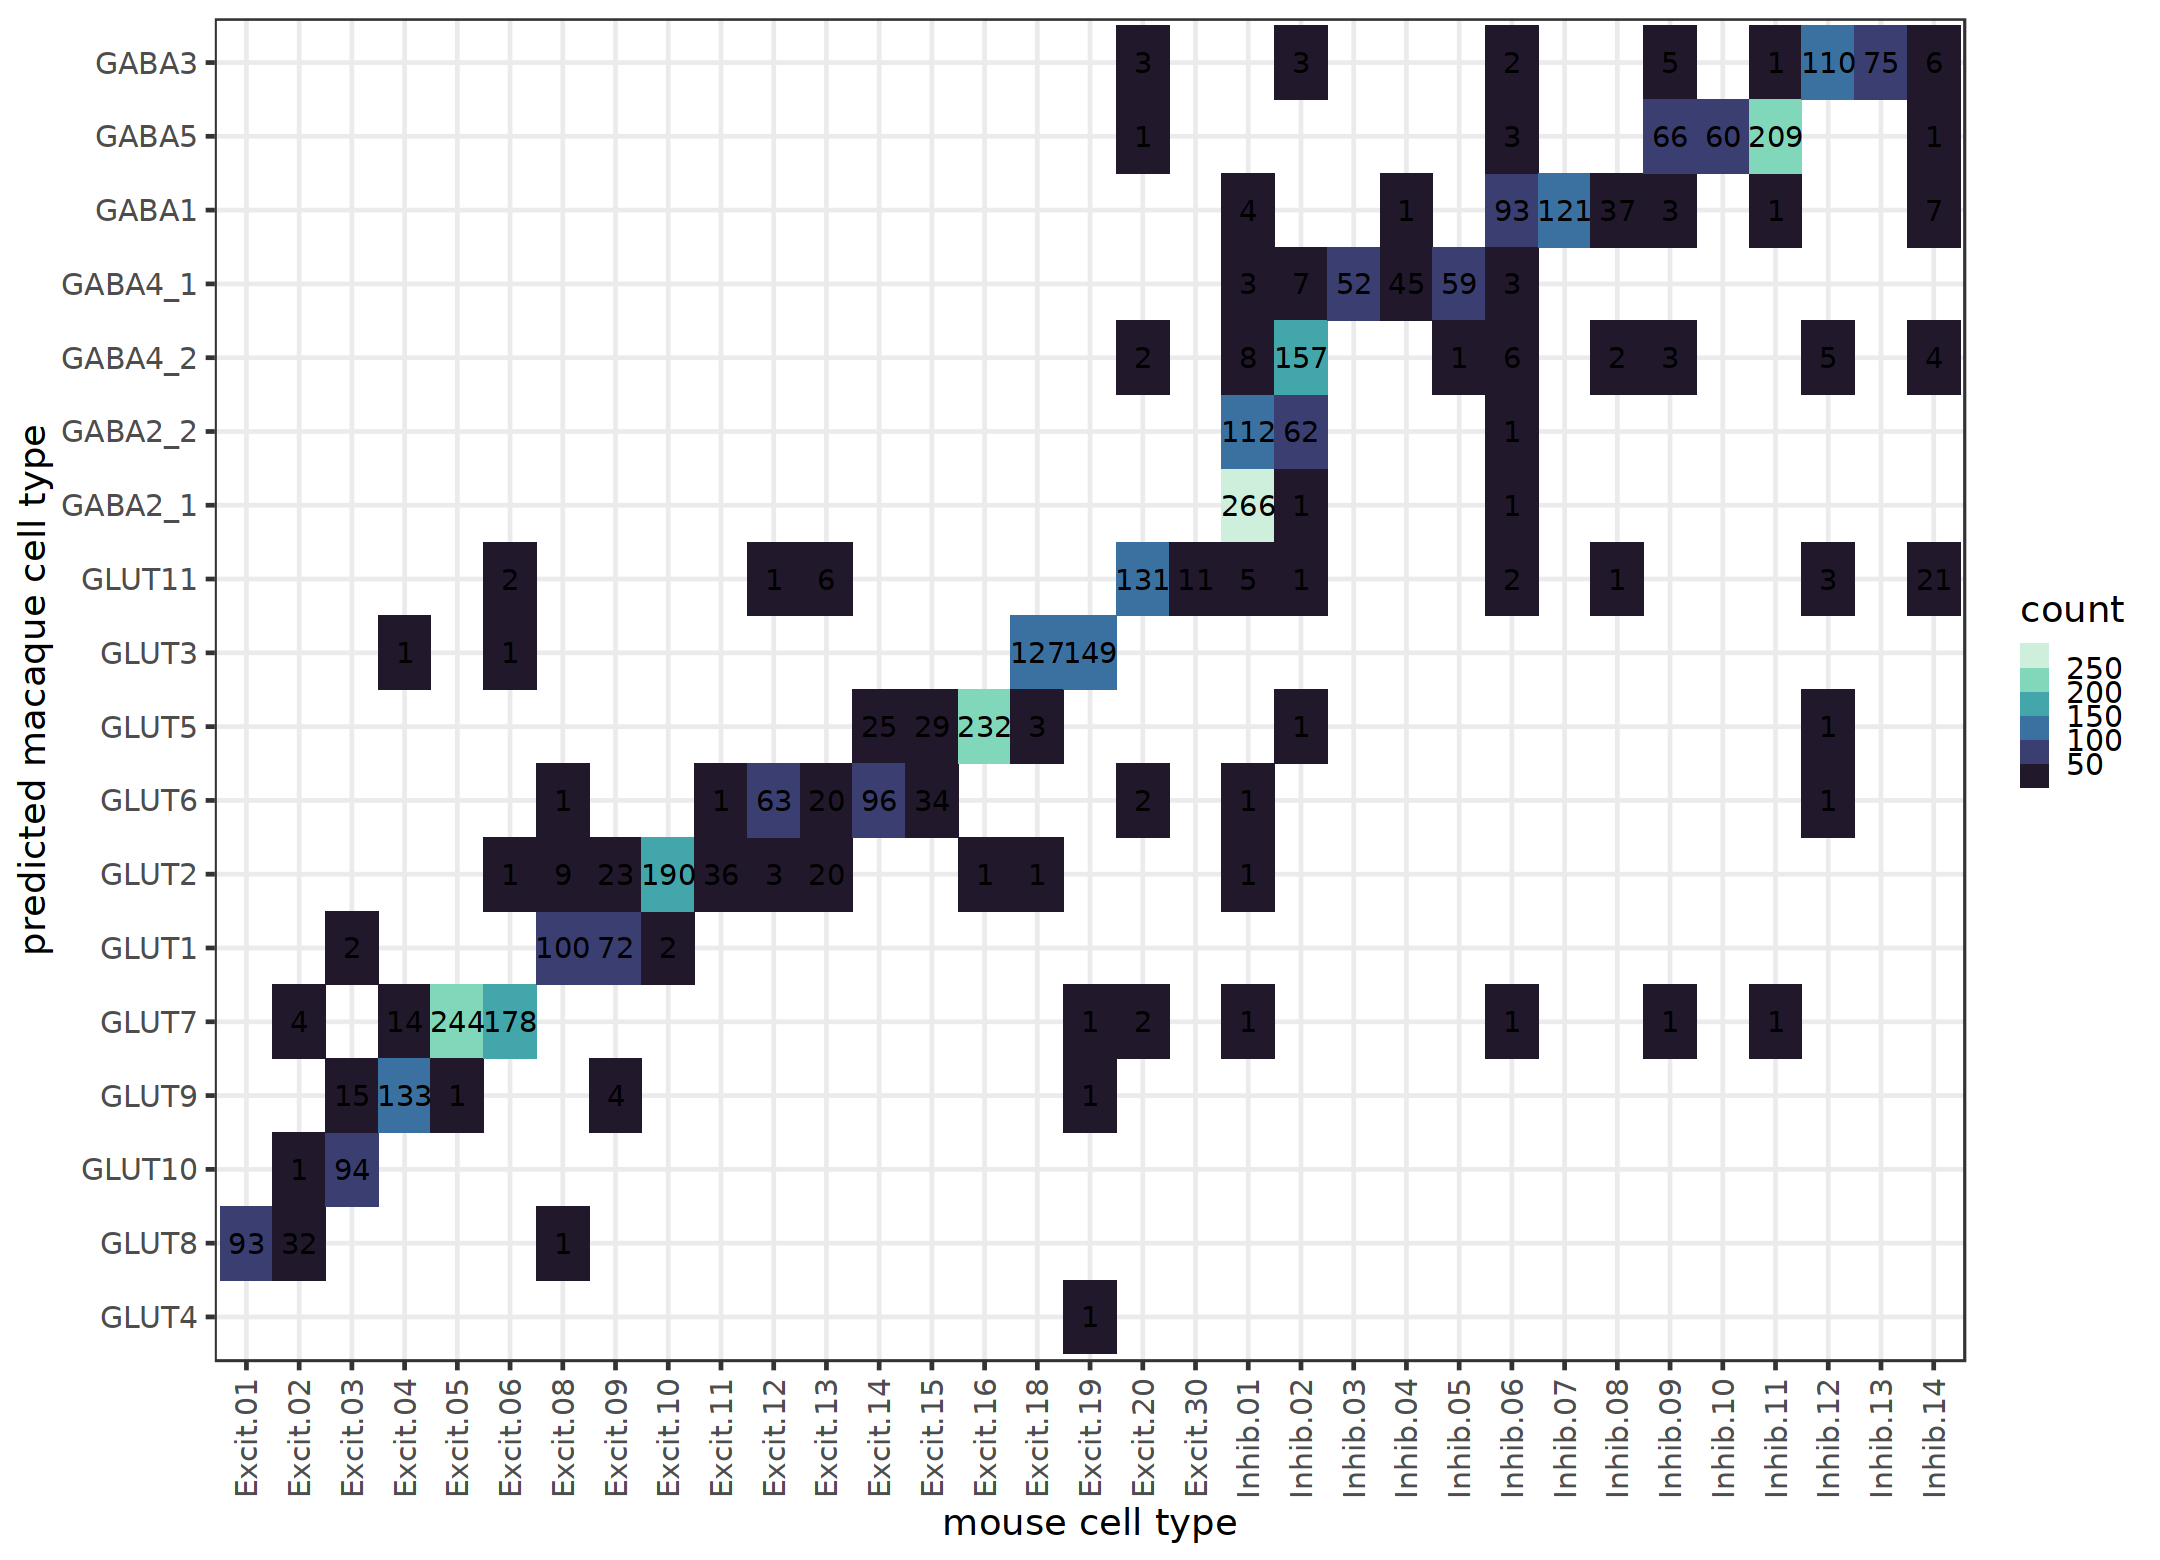

In [29]:
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=13)
macaque_ordered_types = c('GLUT4','GLUT8','GLUT10','GLUT9',
 'GLUT7','GLUT1','GLUT2','GLUT6','GLUT5','GLUT3','GLUT11','GABA2_1','GABA2_2','GABA4_2','GABA4_1',
                          'GABA1','GABA5','GABA3')

## Try a confusion matrix
seurat_object_species1 <- mouse_subset_integrated
seurat_object_species1[[]] %>% 
count(final_cluster_assignment, predicted.id) %>% 
group_by(final_cluster_assignment) %>%
mutate(count = n) %>% 
ungroup() %>% 
ggplot(aes(x = final_cluster_assignment, y = factor(predicted.id,macaque_ordered_types ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 22) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
scale_fill_viridis_b(option = 'mako') +
#scale_fill_distiller()+
geom_text(aes(label =count), color="black", size = 6) +
xlab("mouse cell type") + ylab("predicted macaque cell type")

### different dimension to save
tiff(here(paste0("figures/exploratory/arokiaraj_paper/mouse_integration_labels_",Sys.Date(),".tiff")), units="in", width=12, height=8, res=300)

### Try a confusion matrix
seurat_object_species1 <- mouse_subset_integrated
seurat_object_species1[[]] %>% 
count(final_cluster_assignment, predicted.id) %>% 
group_by(final_cluster_assignment) %>%
mutate(count = n) %>% 
ungroup() %>% 
ggplot(aes(x = final_cluster_assignment, y = factor(predicted.id,macaque_ordered_types ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 14) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5)) +
scale_fill_viridis_b(option = 'mako') +
#scale_fill_distiller()+
geom_text(aes(label =count), color="black", size = 3) +
xlab("mouse cell type") + ylab("predicted macaque cell type")

dev.off()

In [21]:
library(here)
# These variables were already made during integration
saveRDS(mouse_to_macaque_predictions, file = here(paste0("data/tidy_data/rdas/macaque_labels_for_mouse",as.character(Sys.Date()),".rds")))
saveRDS(human_to_macaque_predictions, file = here(paste0("data/tidy_data/rdas/macaque_labels_for_human",as.character(Sys.Date()),".rds")))
saveRDS(mouse_to_human_predictions, file = here(paste0("data/tidy_data/rdas/human_labels_for_mouse",as.character(Sys.Date()),".rds")))

# save integrated dataset
filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/mac_human_mouse_simultaneous_integrated.h5seurat"
SaveH5Seurat(mac_human_mouse.combined, filename)#, overwrite = TRUE)

# save original cell labels so i don't have to load original datasets every time
saveRDS(unique(mouse_rna$final_cluster_assignment), file = here(paste0("data/tidy_data/rdas/original_mouse_labels",as.character(Sys.Date()),".rds")))
saveRDS(unique(human_rna_dh$final_ann), file = here(paste0("data/tidy_data/rdas/original_human_labels",as.character(Sys.Date()),".rds")))
saveRDS(unique(macaque_rna_dh$cluster_type), file = here(paste0("data/tidy_data/rdas/original_macaque_labels",as.character(Sys.Date()),".rds")))

Creating h5Seurat file for version 3.1.5.9900

Adding counts for RNA

Adding data for RNA

No variable features found for RNA

No feature-level metadata found for RNA

Adding data for integrated

Adding scale.data for integrated

Adding variable features for integrated

No feature-level metadata found for integrated

Writing out SCTModel.list for integrated

Adding counts for SCT

Adding data for SCT

Adding scale.data for SCT

No variable features found for SCT

No feature-level metadata found for SCT

Writing out SCTModel.list for SCT

Adding counts for alra

Adding data for alra

No variable features found for alra

No feature-level metadata found for alra

Adding counts for MAGIC_RNA

Adding data for MAGIC_RNA

No variable features found for MAGIC_RNA

No feature-level metadata found for MAGIC_RNA

Adding counts for MAGIC_SCT

Adding data for MAGIC_SCT

No variable features found for MAGIC_SCT

No feature-level metadata found for MAGIC_SCT

Adding cell embeddings for pca

Adding lo

# Visualize Integrated dataset and transfer labels -- load data

In [7]:
macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
new_cell_names = c('Exc-BNC2/HMGA2','Exc-NMUR2/PREX2', 'Exc-NMU/TAC3', 'Exc-TAC3/COL5A2/PLCH1','Exc-LMO3/TRPC3', 'Exc-SKOR2/NELL2', 'Exc-MAF/ADARB2', 'Exc-MAFA/BNC2', 
                  'Exc-NTS/TSHZ2', 'Exc-SNTB1/TRH/DACH1', 'Exc-PBX3/SLIT2', 
                  'Inh-CACNA2D3/TCF4', 'Inh-SORCS1/SDK1', 'Inh-PDZD2/SGCD', 'Inh-NPY/ZIC1', 'Inh-MEF2C/RORB','Inh-NXPH1/SDK2','Inh-PDYN/PTPRK')
names(new_cell_names) = macaque_ordered_types

new_nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-NTS', 'Exc-SNTB1', 'Exc-PBX3','Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
names(new_nicknames) = new_cell_names

human_to_macaque_predictions = readRDS(file = here("data/tidy_data/rdas/macaque_labels_for_human2023-08-16.rds"))
mouse_to_macaque_predictions = readRDS(file = here("data/tidy_data/rdas/macaque_labels_for_mouse2023-08-16.rds"))

human_to_macaque_predictions_new = new_cell_names[human_to_macaque_predictions$predicted.id]
mouse_to_macaque_predictions_new = new_cell_names[mouse_to_macaque_predictions$predicted.id]



In [19]:
library(here)
original_mouse_labels <- readRDS(here(paste0("data/tidy_data/rdas/original_mouse_labels",'2023-08-16',".rds")))
original_human_labels <- readRDS(here(paste0("data/tidy_data/rdas/original_human_labels",'2023-08-16',".rds")))
original_macaque_labels <- readRDS(here(paste0("data/tidy_data/rdas/original_macaque_labels",'2023-08-16',".rds")))

mouse_to_macaque_predictions <- readRDS(here(paste0("data/tidy_data/rdas/macaque_labels_for_mouse",'2023-08-16',".rds")))
human_to_macaque_predictions <- readRDS(here(paste0("data/tidy_data/rdas/macaque_labels_for_human",'2023-08-16',".rds")))
mouse_to_human_predictions <- readRDS(here(paste0("data/tidy_data/rdas/human_labels_for_mouse",'2023-08-16',".rds")))

In [8]:
# Load integrated dataset and saved label predictions
mac_human_mouse.combined = LoadH5Seurat("/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/mac_human_mouse_simultaneous_integrated.h5seurat")
mac_human_mouse.combined$cluster_type[mac_human_mouse.combined$cluster_type == 'NA'] <- NA
mac_human_mouse.combined$final_ann[mac_human_mouse.combined$final_ann == 'NA'] <- NA
mac_human_mouse.combined$final_cluster_assignment[mac_human_mouse.combined$final_cluster_assignment == 'NA'] <- NA

### add cell names
mac_human_mouse.combined$human_predicted <- mac_human_mouse.combined$final_ann
mac_human_mouse.combined$human_predicted[!is.na(mac_human_mouse.combined$human_predicted)] = human_to_macaque_predictions_new

mac_human_mouse.combined$mouse_predicted <- mac_human_mouse.combined$final_cluster_assignment
mac_human_mouse.combined$mouse_predicted[!is.na(mac_human_mouse.combined$mouse_predicted)] = mouse_to_macaque_predictions_new

mac_human_mouse.combined$conserved_marker_names = mac_human_mouse.combined$cluster_type
mac_human_mouse.combined$conserved_marker_names[!is.na(mac_human_mouse.combined$conserved_marker_names)] = new_cell_names[mac_human_mouse.combined$conserved_marker_names[!is.na(mac_human_mouse.combined$conserved_marker_names)]]

### add nicknames
mac_human_mouse.combined$human_predicted_nicknames <- new_nicknames[mac_human_mouse.combined$human_predicted]
mac_human_mouse.combined$mouse_predicted_nicknames <- new_nicknames[mac_human_mouse.combined$mouse_predicted]
mac_human_mouse.combined$conserved_marker_nicknames <- new_nicknames[mac_human_mouse.combined$conserved_marker_names]

# Name NA's as Other Species
mac_human_mouse.combined$human_predicted[is.na(mac_human_mouse.combined$human_predicted)] = 'Other Species'
mac_human_mouse.combined$conserved_marker_names[is.na(mac_human_mouse.combined$conserved_marker_names)] = 'Other Species'
mac_human_mouse.combined$mouse_predicted[is.na(mac_human_mouse.combined$mouse_predicted)] = 'Other Species'

mac_human_mouse.combined$human_predicted_nicknames[is.na(mac_human_mouse.combined$human_predicted_nicknames)] = 'Other Species'
mac_human_mouse.combined$conserved_marker_nicknames[is.na(mac_human_mouse.combined$conserved_marker_nicknames)] = 'Other Species'
mac_human_mouse.combined$mouse_predicted_nicknames[is.na(mac_human_mouse.combined$mouse_predicted_nicknames)] = 'Other Species'

Validating h5Seurat file

Initializing MAGIC_RNA with data

Adding counts for MAGIC_RNA

Adding miscellaneous information for MAGIC_RNA

Initializing MAGIC_SCT with data

Adding counts for MAGIC_SCT

Adding miscellaneous information for MAGIC_SCT

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding miscellaneous information for SCT

Initializing alra with data

Adding counts for alra

Adding miscellaneous information for alra

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from MAGIC_RNA_ to MAGICRNA_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from MAGIC_SCT_ to MAGICSCT

In [9]:
save_integration_figs = TRUE

human_ordered_types = c('Ex-Dorsal-1','Ex-Dorsal-2','Ex-Dorsal-3','Ex-Dorsal-4','Ex-Dorsal-5','Ex-Dorsal-6',
                        'Ex-Dorsal-7','Ex-Dorsal-8','Ex-Dorsal-9','Ex-Dorsal-10','Ex-Dorsal-11','Ex-Dorsal-12',
                        'Inh-Dorsal-1','Inh-Dorsal-2','Inh-Dorsal-3','Inh-Dorsal-4','Inh-Dorsal-5','Inh-Dorsal-6',
                        'Inh-Dorsal-7','Inh-Dorsal-8','Inh-Dorsal-9')
# colors

cols = DiscretePalette(length(unique(mac_human_mouse.combined$human_predicted)))
cols2 = DiscretePalette(length(unique(mac_human_mouse.combined$human_predicted)) + 1)
cols[1] = 'grey80'

cols_macaque <- cols
cols_macaque <- append(cols_macaque, cols2[19], after=15)
cols_macaque
cols

[1] "grey80"  "#0075DC" "#993F00" "#4C005C" "#191919" "#005C31" "#2BCE48"
 [8] "#FFCC99" "#808080" "#94FFB5" "#8F7C00" "#9DCC00" "#C20088" "#003380"
[15] "#FFA405" "#5EF1F2" "#FFA8BB" "#426600" "#FF0010"

[1] "grey80"  "#0075DC" "#993F00" "#4C005C" "#191919" "#005C31" "#2BCE48"
 [8] "#FFCC99" "#808080" "#94FFB5" "#8F7C00" "#9DCC00" "#C20088" "#003380"
[15] "#FFA405" "#FFA8BB" "#426600" "#FF0010"

In [21]:
# subset data with label predictions
human_subset_integrated <- mac_human_mouse.combined
human_subset_integrated <- subset(x = mac_human_mouse.combined, subset = final_ann %in% original_human_labels)

mouse_subset_integrated <- mac_human_mouse.combined
mouse_subset_integrated = subset(x = mac_human_mouse.combined, subset = final_cluster_assignment %in% original_mouse_labels)
mouse_human_names <- mouse_subset_integrated

macaque_subset_integrated <- mac_human_mouse.combined
macaque_subset_integrated = subset(x = mac_human_mouse.combined, subset = cluster_type %in% original_macaque_labels)

human_subset_integrated <- AddMetaData(object = human_subset_integrated, metadata = human_to_macaque_predictions)
mouse_subset_integrated <- AddMetaData(object = mouse_subset_integrated, metadata = mouse_to_macaque_predictions)
mouse_human_names <- AddMetaData(object = mouse_subset_integrated, metadata = mouse_to_human_predictions)

# Integrated data - Make figures for paper

png 
  2

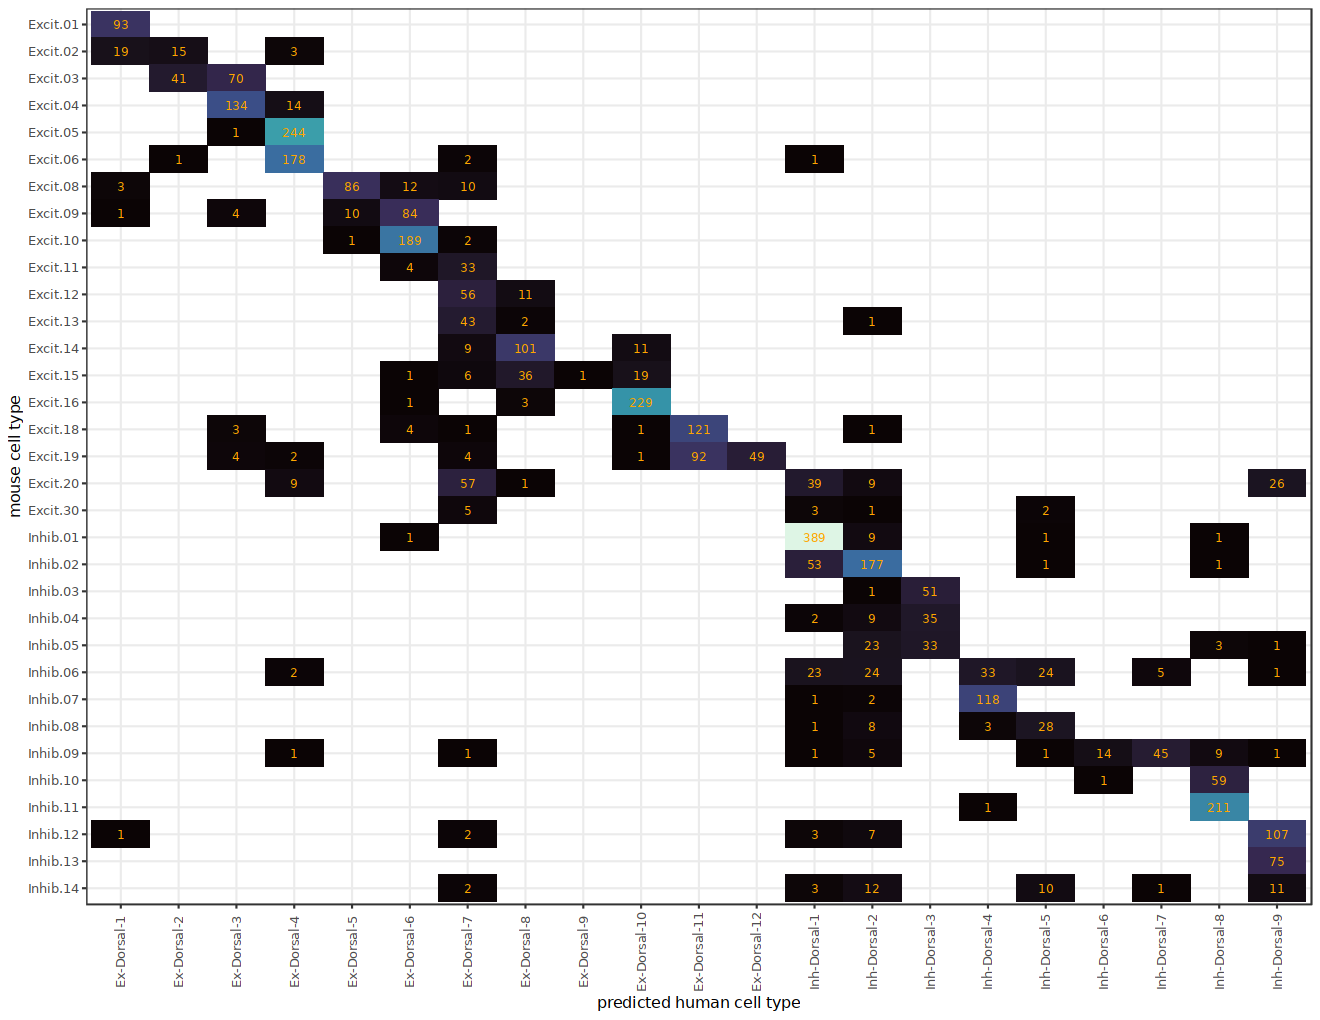

In [23]:
### Mouse and human - same clusters matched
### (flipped like in the Levine paper)
### Supplemental Figure S
#options(repr.plot.width=18, repr.plot.height=13)

## Plot in Jupyter
seurat_object_species1 <- mouse_human_names
data = seurat_object_species1[[]] %>% 
count(final_cluster_assignment, predicted.id) %>% 
group_by(final_cluster_assignment) %>%
mutate(count = n) %>% 
ungroup()
p = ggplot(data, aes(x = factor(predicted.id,human_ordered_types), y = factor(final_cluster_assignment,rev(sort(original_mouse_labels))),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 10) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5), text = element_text(size=9,face="bold"),
                                legend.position = 'none') +
scale_fill_viridis_c(option = 'mako') +
#scale_fill_distiller()+
geom_text(aes(label =count), color="orange", size = 2.5) +
xlab("predicted human cell type") + ylab("mouse cell type")
p

if (save_integration_figs){

    pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/labelTransfer_mouse_human",Sys.Date(),".pdf")), width = 5.5, height = 5.5)
    print(p)
    dev.off()
}

png 
  2

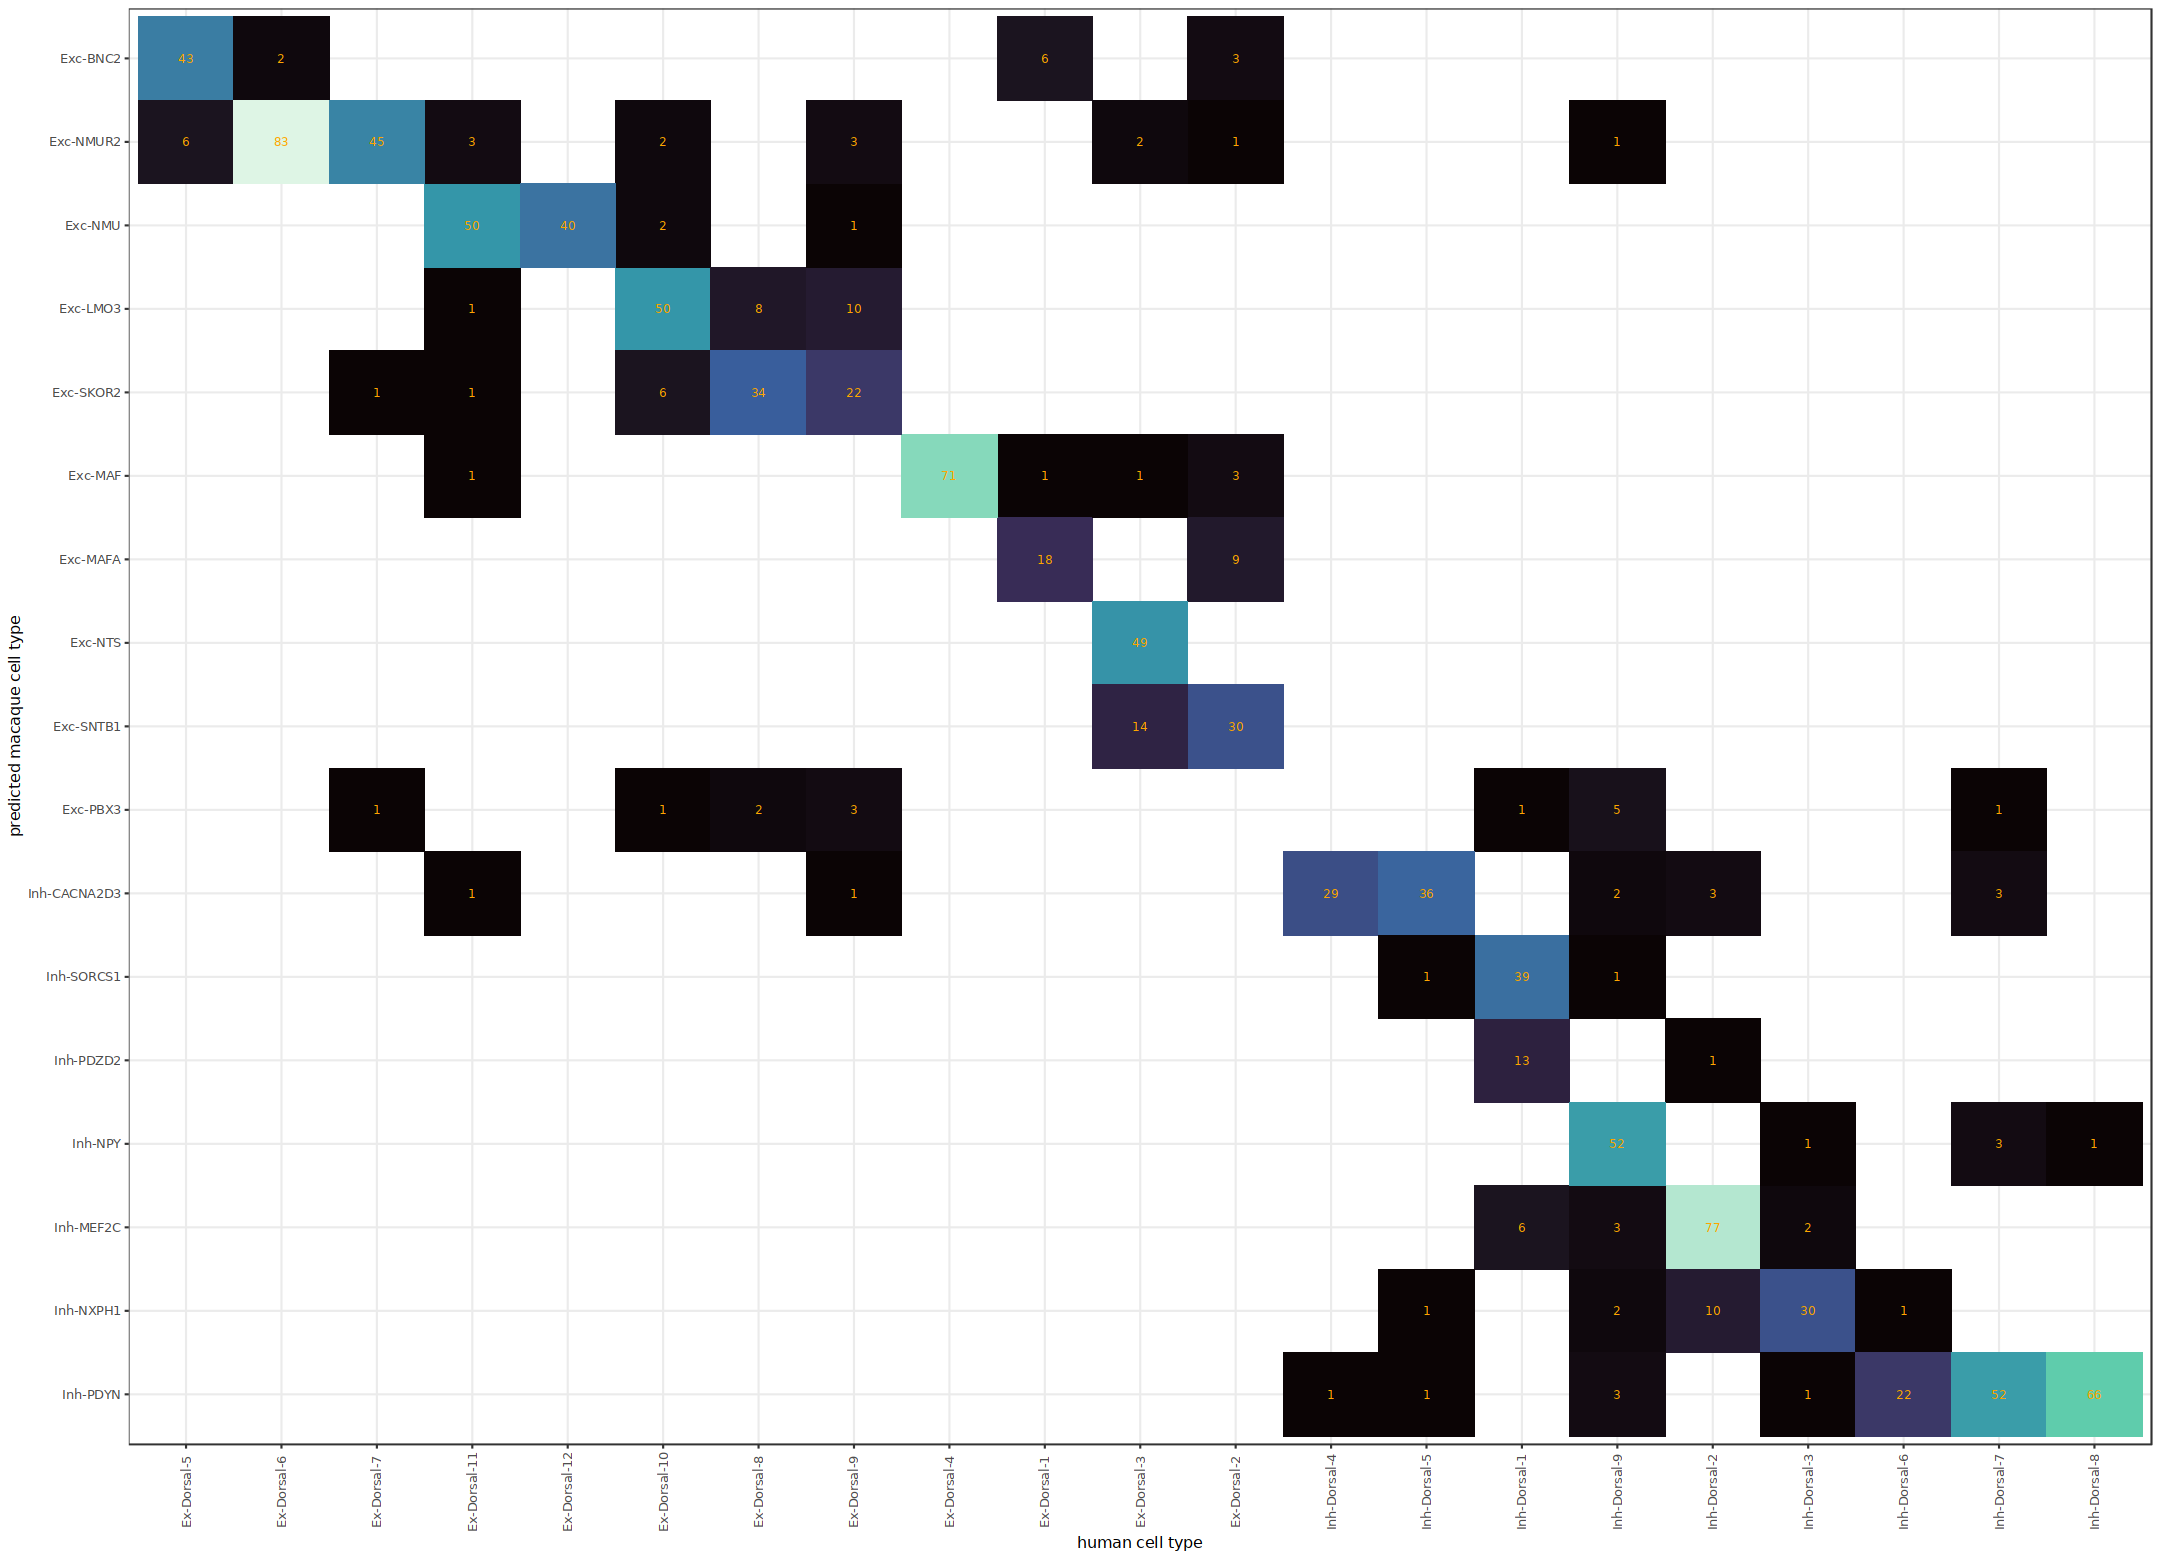

In [24]:
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=13)

human_v_macaque_types = c('Ex-Dorsal-5','Ex-Dorsal-6','Ex-Dorsal-7','Ex-Dorsal-11','Ex-Dorsal-12',
                        'Ex-Dorsal-10','Ex-Dorsal-8','Ex-Dorsal-9','Ex-Dorsal-4','Ex-Dorsal-1',
                        'Ex-Dorsal-3','Ex-Dorsal-2',
                        'Inh-Dorsal-4','Inh-Dorsal-5','Inh-Dorsal-1','Inh-Dorsal-9',
                        'Inh-Dorsal-2','Inh-Dorsal-3','Inh-Dorsal-6','Inh-Dorsal-7','Inh-Dorsal-8')

## Try a confusion matrix
nicknames_to_predict = new_nicknames
names(nicknames_to_predict) = macaque_ordered_types
human_subset_integrated$predicted_nicknames = nicknames_to_predict[human_subset_integrated$predicted.id]


seurat_object_species1 <- human_subset_integrated
data = seurat_object_species1[[]] %>% 
count(final_ann, predicted_nicknames) %>% 
group_by(final_ann) %>%
mutate(count = n) %>% 
ungroup()
p = ggplot(data, aes(x = factor(final_ann,human_v_macaque_types), y = factor(predicted_nicknames,rev(new_nicknames) ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 10) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5),text = element_text(size=9,face="bold"), 
                                 legend.position = 'off') +
scale_fill_viridis_c(option = 'mako') +
geom_text(aes(label =count), color="orange", size = 2.5) +
xlab("human cell type") + ylab("predicted macaque cell type") + scale_y_discrete(labels= new_nicknames)

print(p)

if (save_integration_figs){

    pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/labelTransfer_macaque_human",Sys.Date(),".pdf")), width = 5.5, height = 4)
    print(p)
    dev.off()
}

In [28]:
library(ggpubr)
options(repr.plot.width=18, repr.plot.height=13)
macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
mouse_ordered_types = c('Excit.08','Excit.09','Excit.10','Excit.11','Excit.18','Excit.19','Excit.16','Excit.12','Excit.13','Excit.14', 'Excit.15',
                        'Excit.05','Excit.06','Excit.01','Excit.02','Excit.04','Excit.03','Excit.20','Excit.30',
                        'Inhib.06','Inhib.07','Inhib.08','Inhib.01','Inhib.02','Inhib.12','Inhib.13',
                        'Inhib.03','Inhib.04','Inhib.05','Inhib.09','Inhib.10','Inhib.11','Inhib.14')

## add new nicknames
mouse_subset_integrated$predicted_nicknames = nicknames_to_predict[mouse_subset_integrated$predicted.id]



## Try a confusion matrix
seurat_object_species1 <- mouse_subset_integrated
data = seurat_object_species1[[]] %>% 
count(final_cluster_assignment, predicted_nicknames) %>% 
group_by(final_cluster_assignment) %>%
mutate(count = n) %>% 
ungroup()
p = ggplot(data, aes(x = factor(final_cluster_assignment,mouse_ordered_types), y = factor(predicted_nicknames,rev(new_nicknames) ),
           fill = count)) + 
geom_tile() + 
theme_bw(base_size = 10) + theme(axis.text.x = element_text(angle = 90, vjust = 0.5), text = element_text(size=9,face="bold"),
                                legend.position = 'none') +
scale_fill_viridis_c(option = 'mako') +
#scale_fill_distiller()+
geom_text(aes(label =count), color="orange", size = 2.5) +
xlab("mouse cell type") + ylab("predicted macaque cell type")

if (save_integration_figs){

    pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/labelTransfer_macaque_mouse",Sys.Date(),".pdf")), width = 7.5, height = 4)
    print(p)
    dev.off()
}

png 
  2

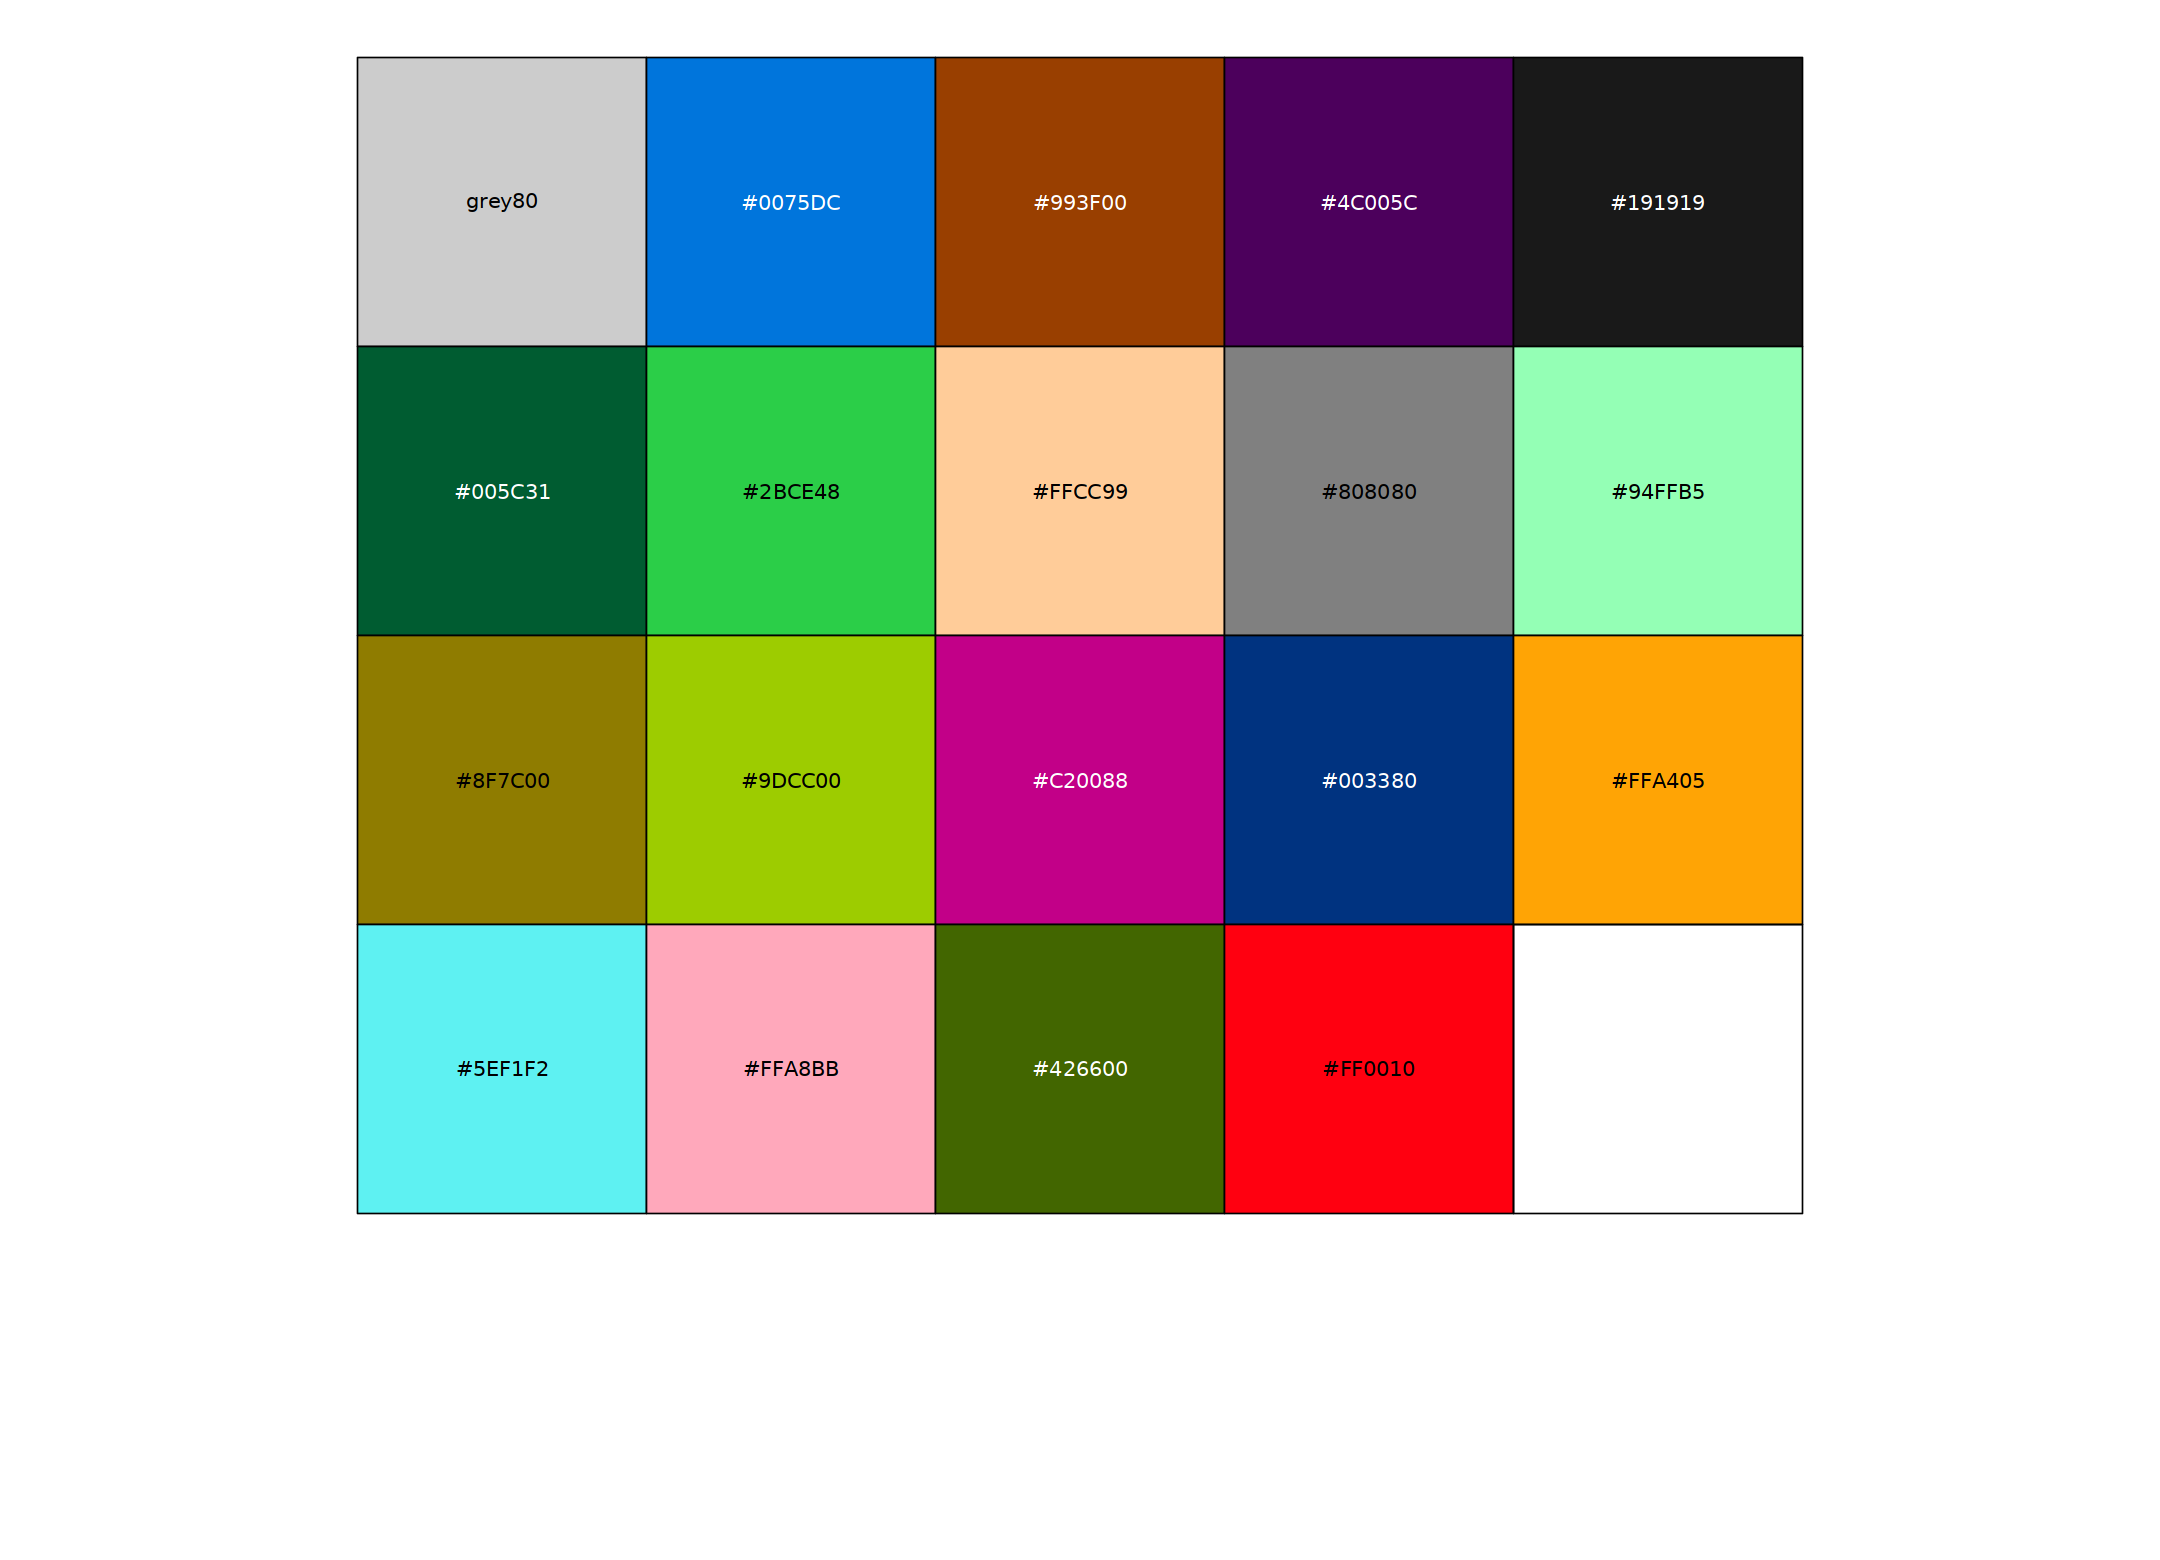

In [196]:
show_col(cols_macaque)

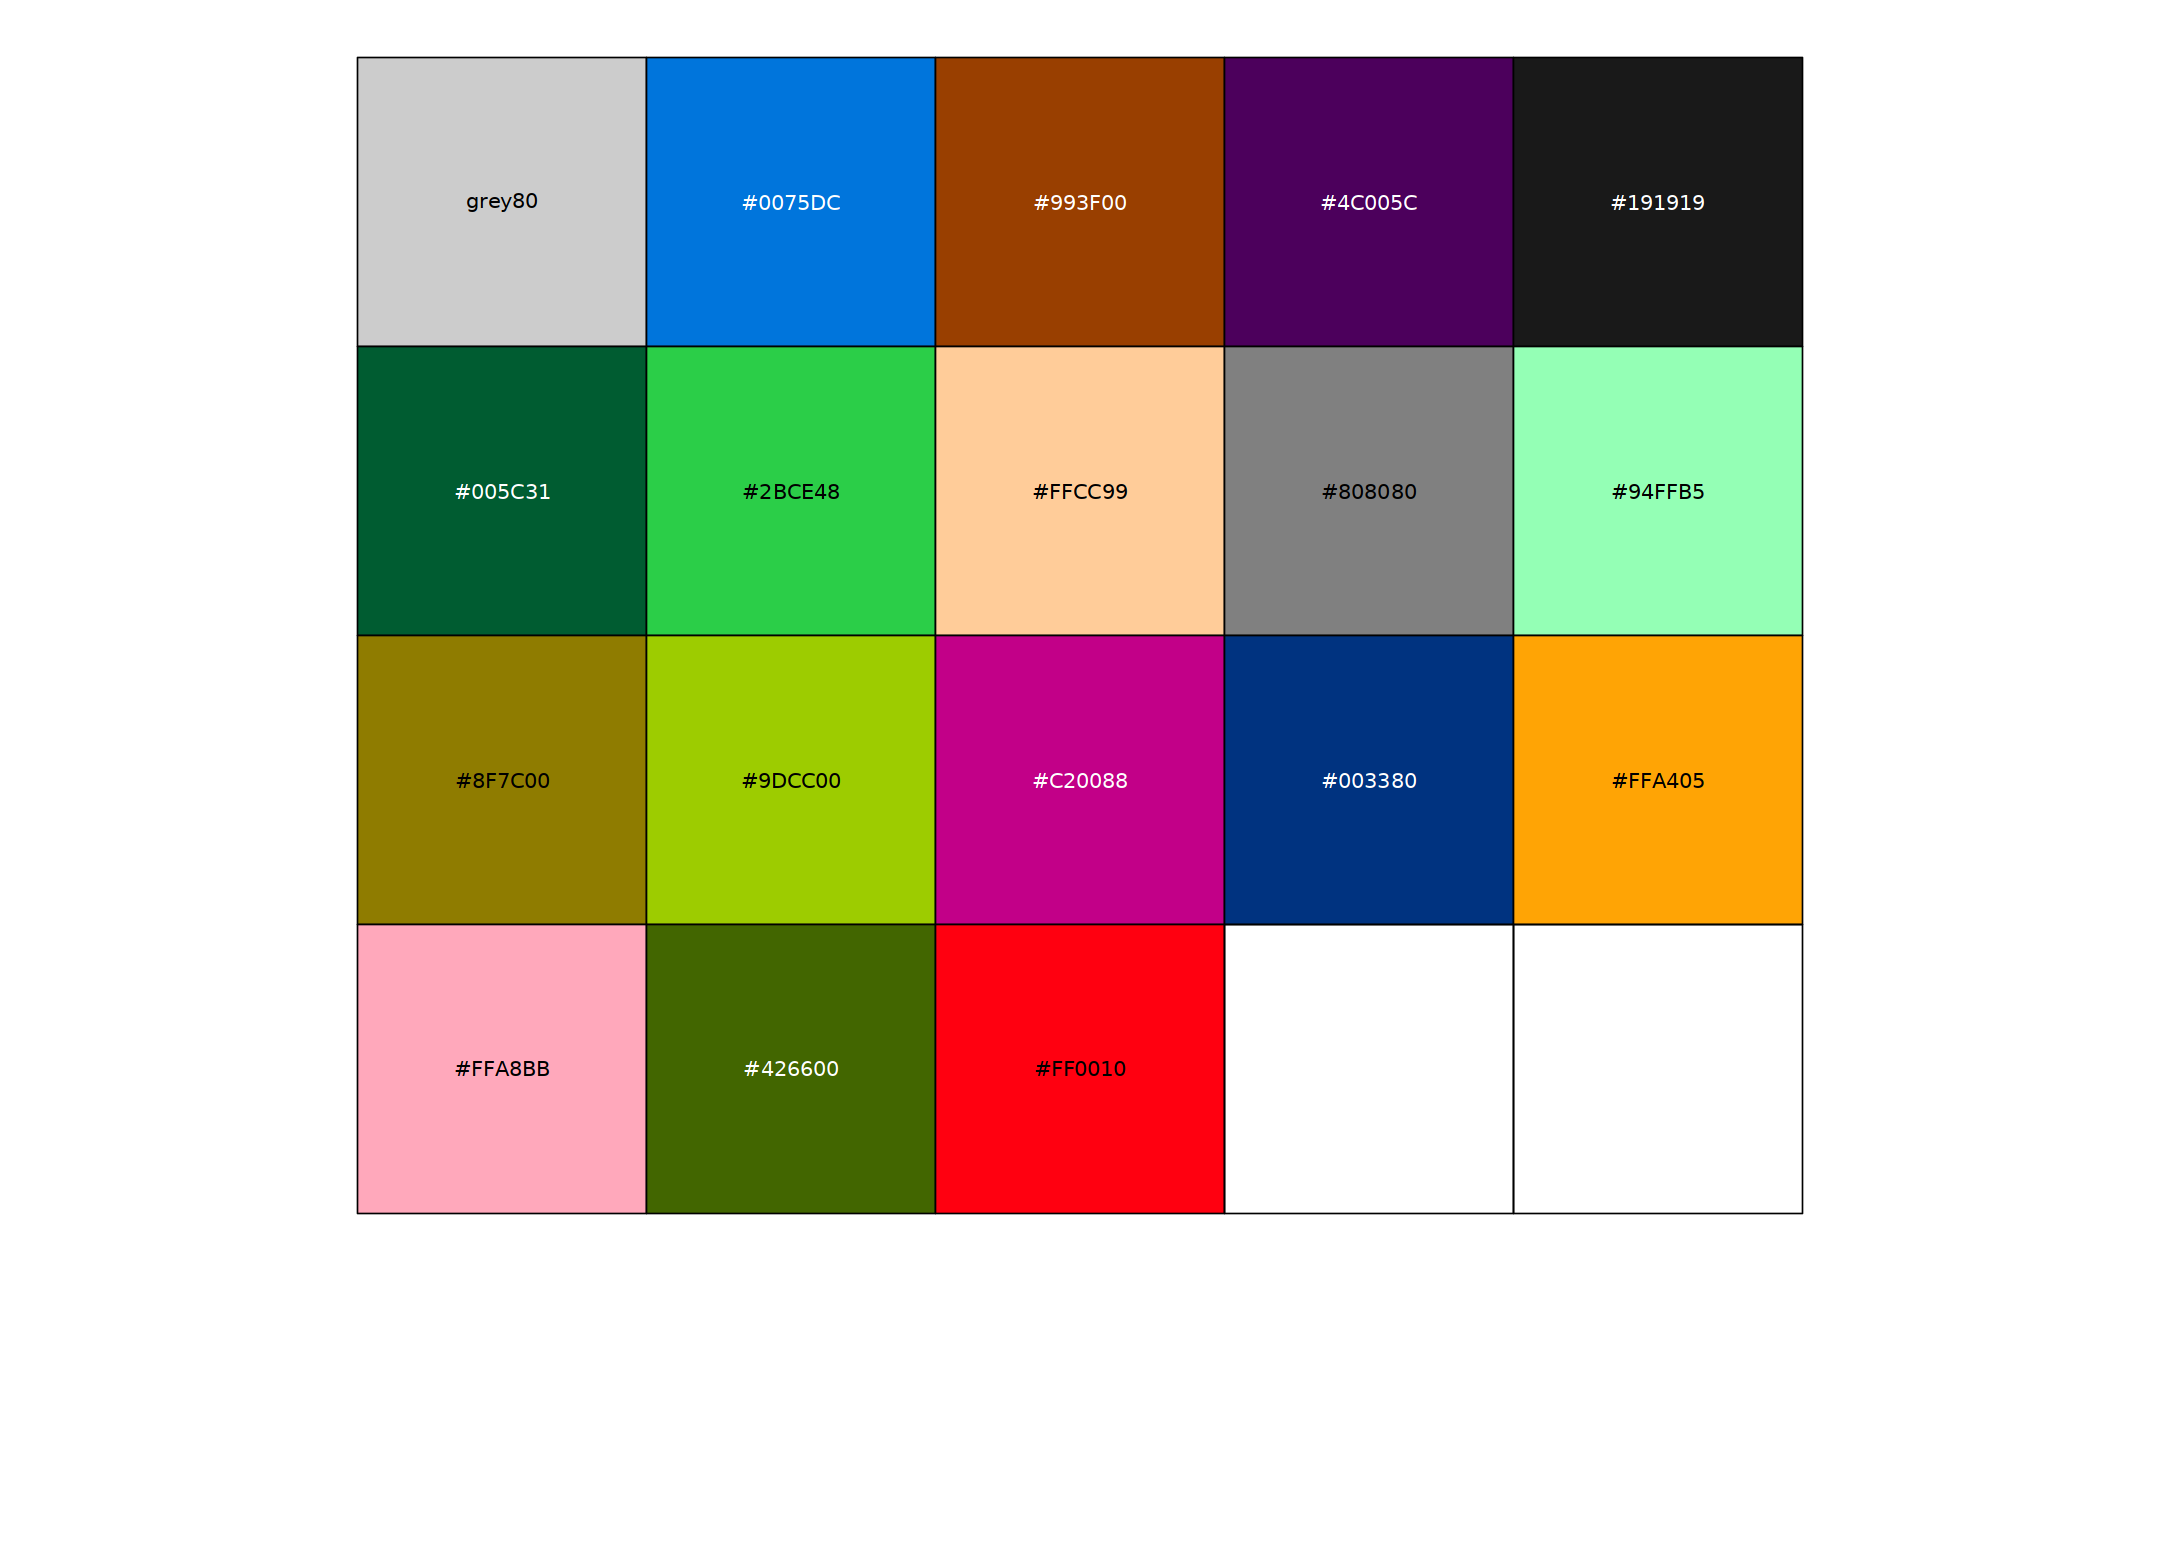

In [197]:
show_col(cols)

In [185]:
unique(mac_human_mouse.combined$human_predicted_nicknames)#, levels=c('Other Species',new_nicknames)))
unique(mac_human_mouse.combined$mouse_predicted_nicknames)#, levels=c('Other Species',new_nicknames)))
#new_nicknames

[1] "Exc-NMUR2"     "Inh-PDYN"      "Exc-LMO3"      "Inh-MEF2C"    
 [5] "Exc-NMU"       "Exc-SNTB1"     "Inh-CACNA2D3"  "Exc-MAFA"     
 [9] "Exc-MAF"       "Inh-SORCS1"    "Inh-NXPH1"     "Exc-SKOR2"    
[13] "Inh-NPY"       "Exc-BNC2"      "Exc-NTS"       "Inh-PDZD2"    
[17] "Exc-PBX3"      "Other Species"

[1] "Other Species" "Exc-LMO3"      "Inh-SORCS1"    "Inh-MEF2C"    
 [5] "Exc-NMUR2"     "Exc-NTS"       "Inh-NXPH1"     "Exc-SKOR2"    
 [9] "Exc-MAFA"      "Exc-NMU"       "Inh-PDYN"      "Exc-MAF"      
[13] "Inh-NPY"       "Inh-CACNA2D3"  "Inh-PDZD2"     "Exc-SNTB1"    
[17] "Exc-PBX3"      "Exc-BNC2"      "Exc-TAC3"

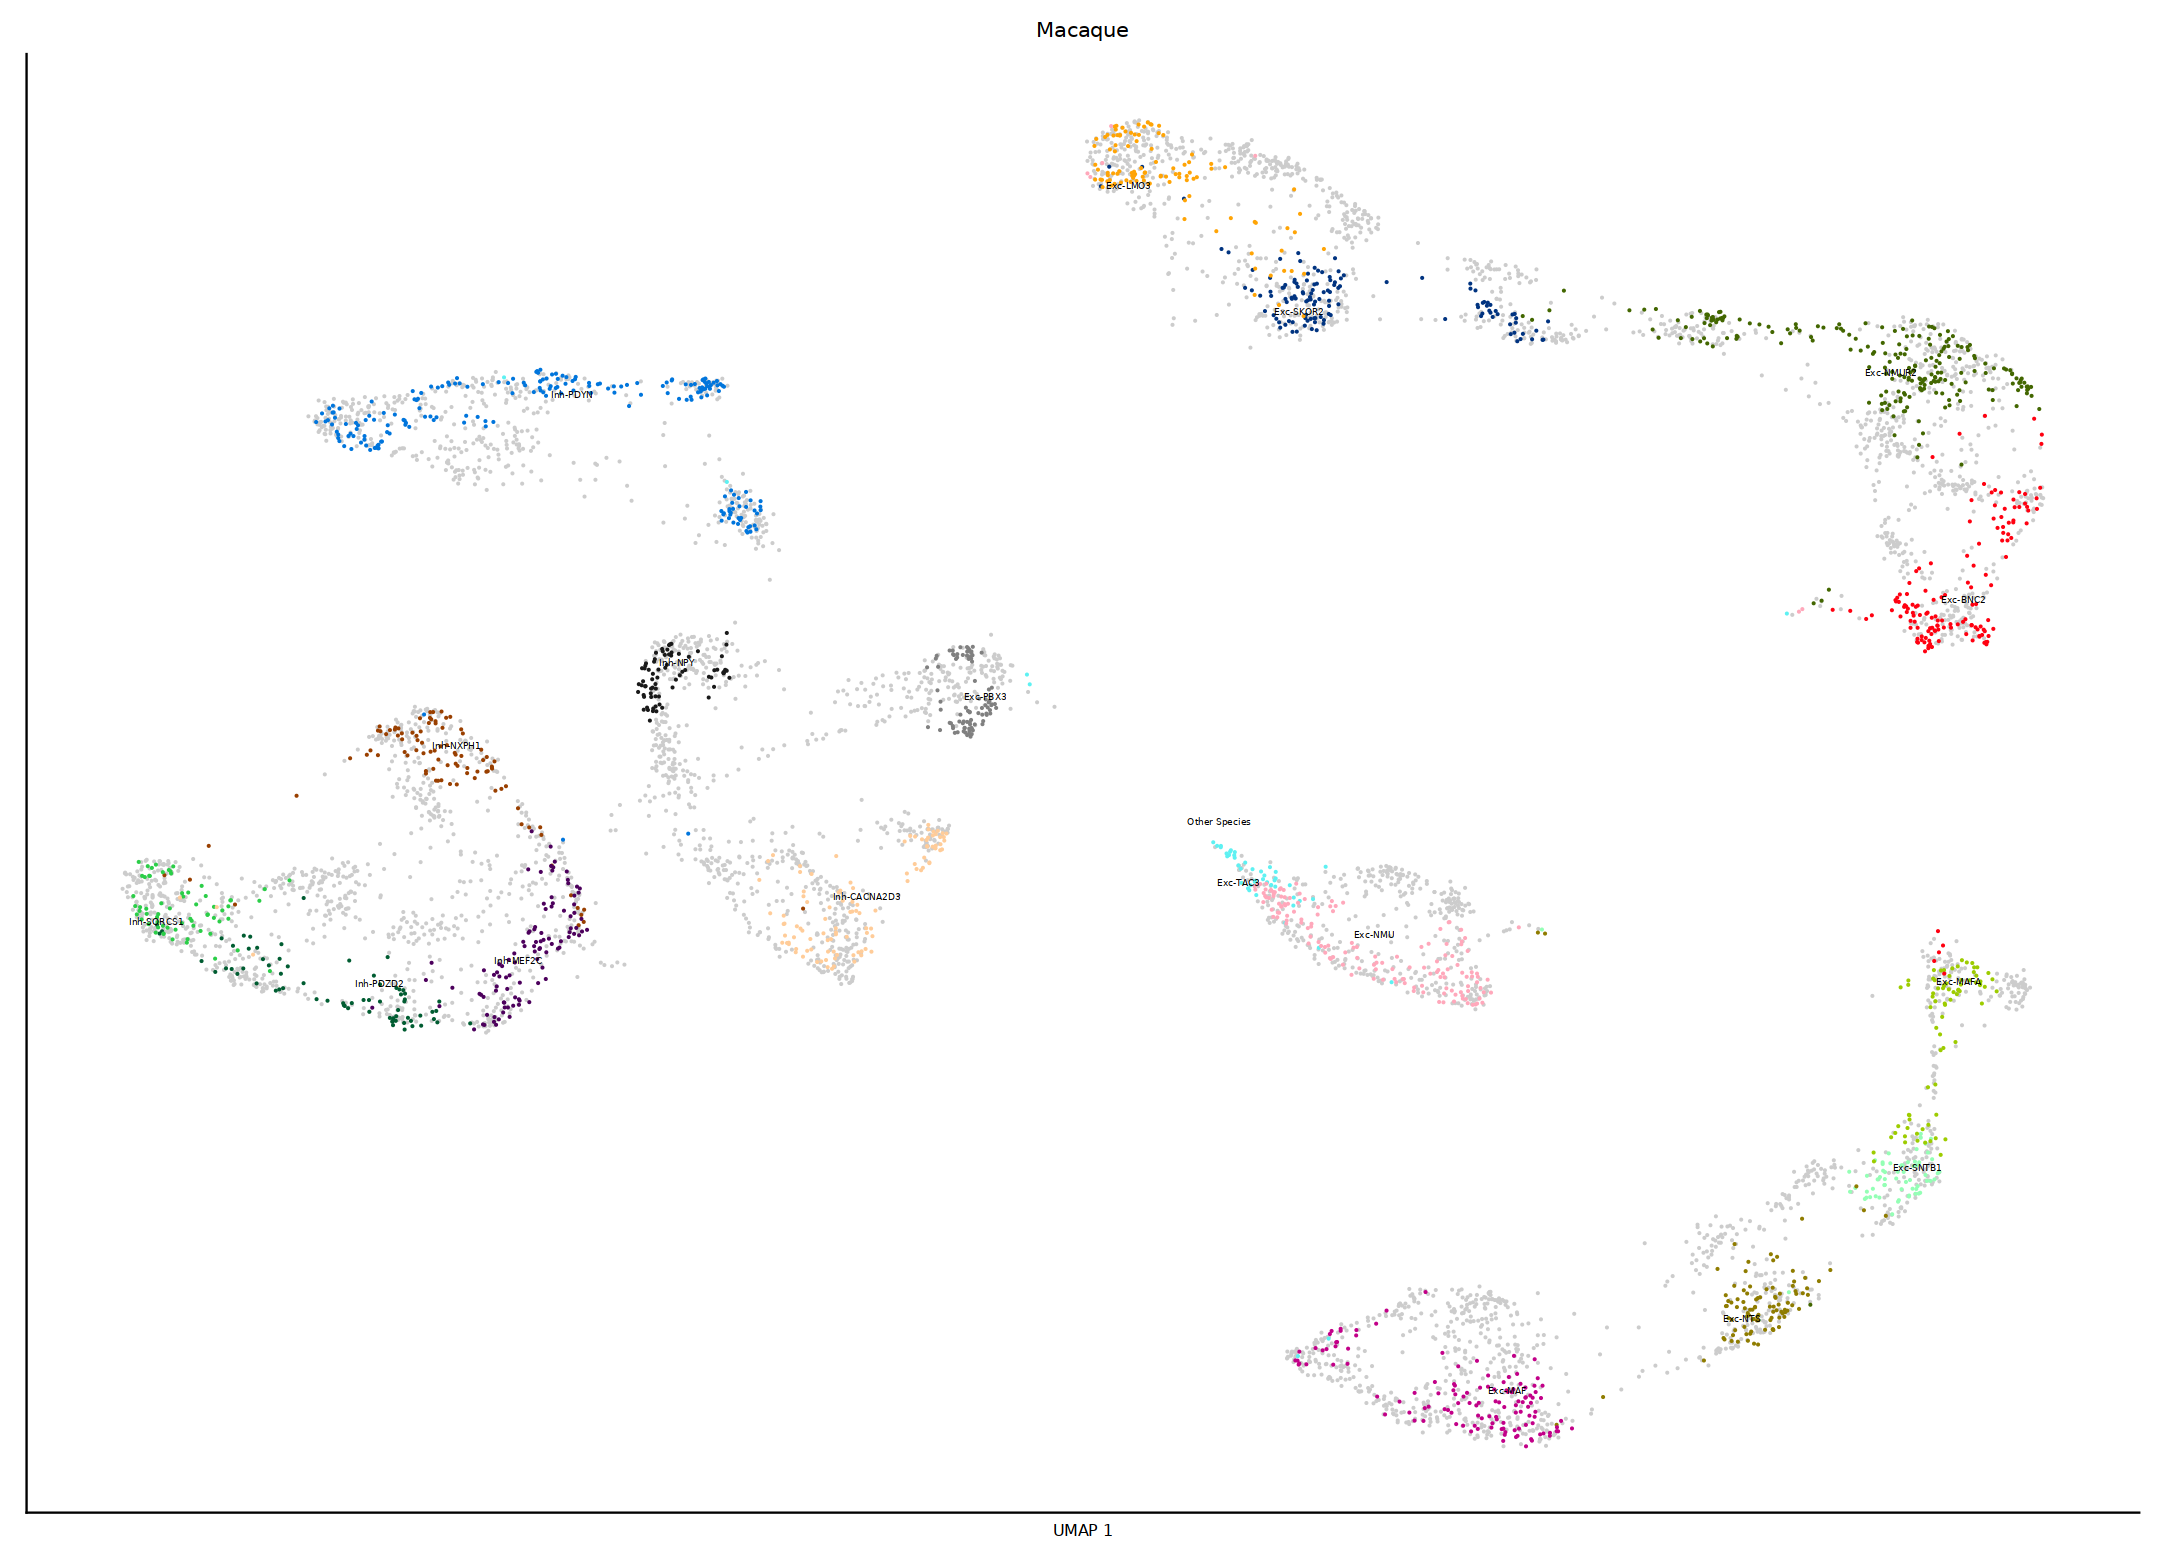

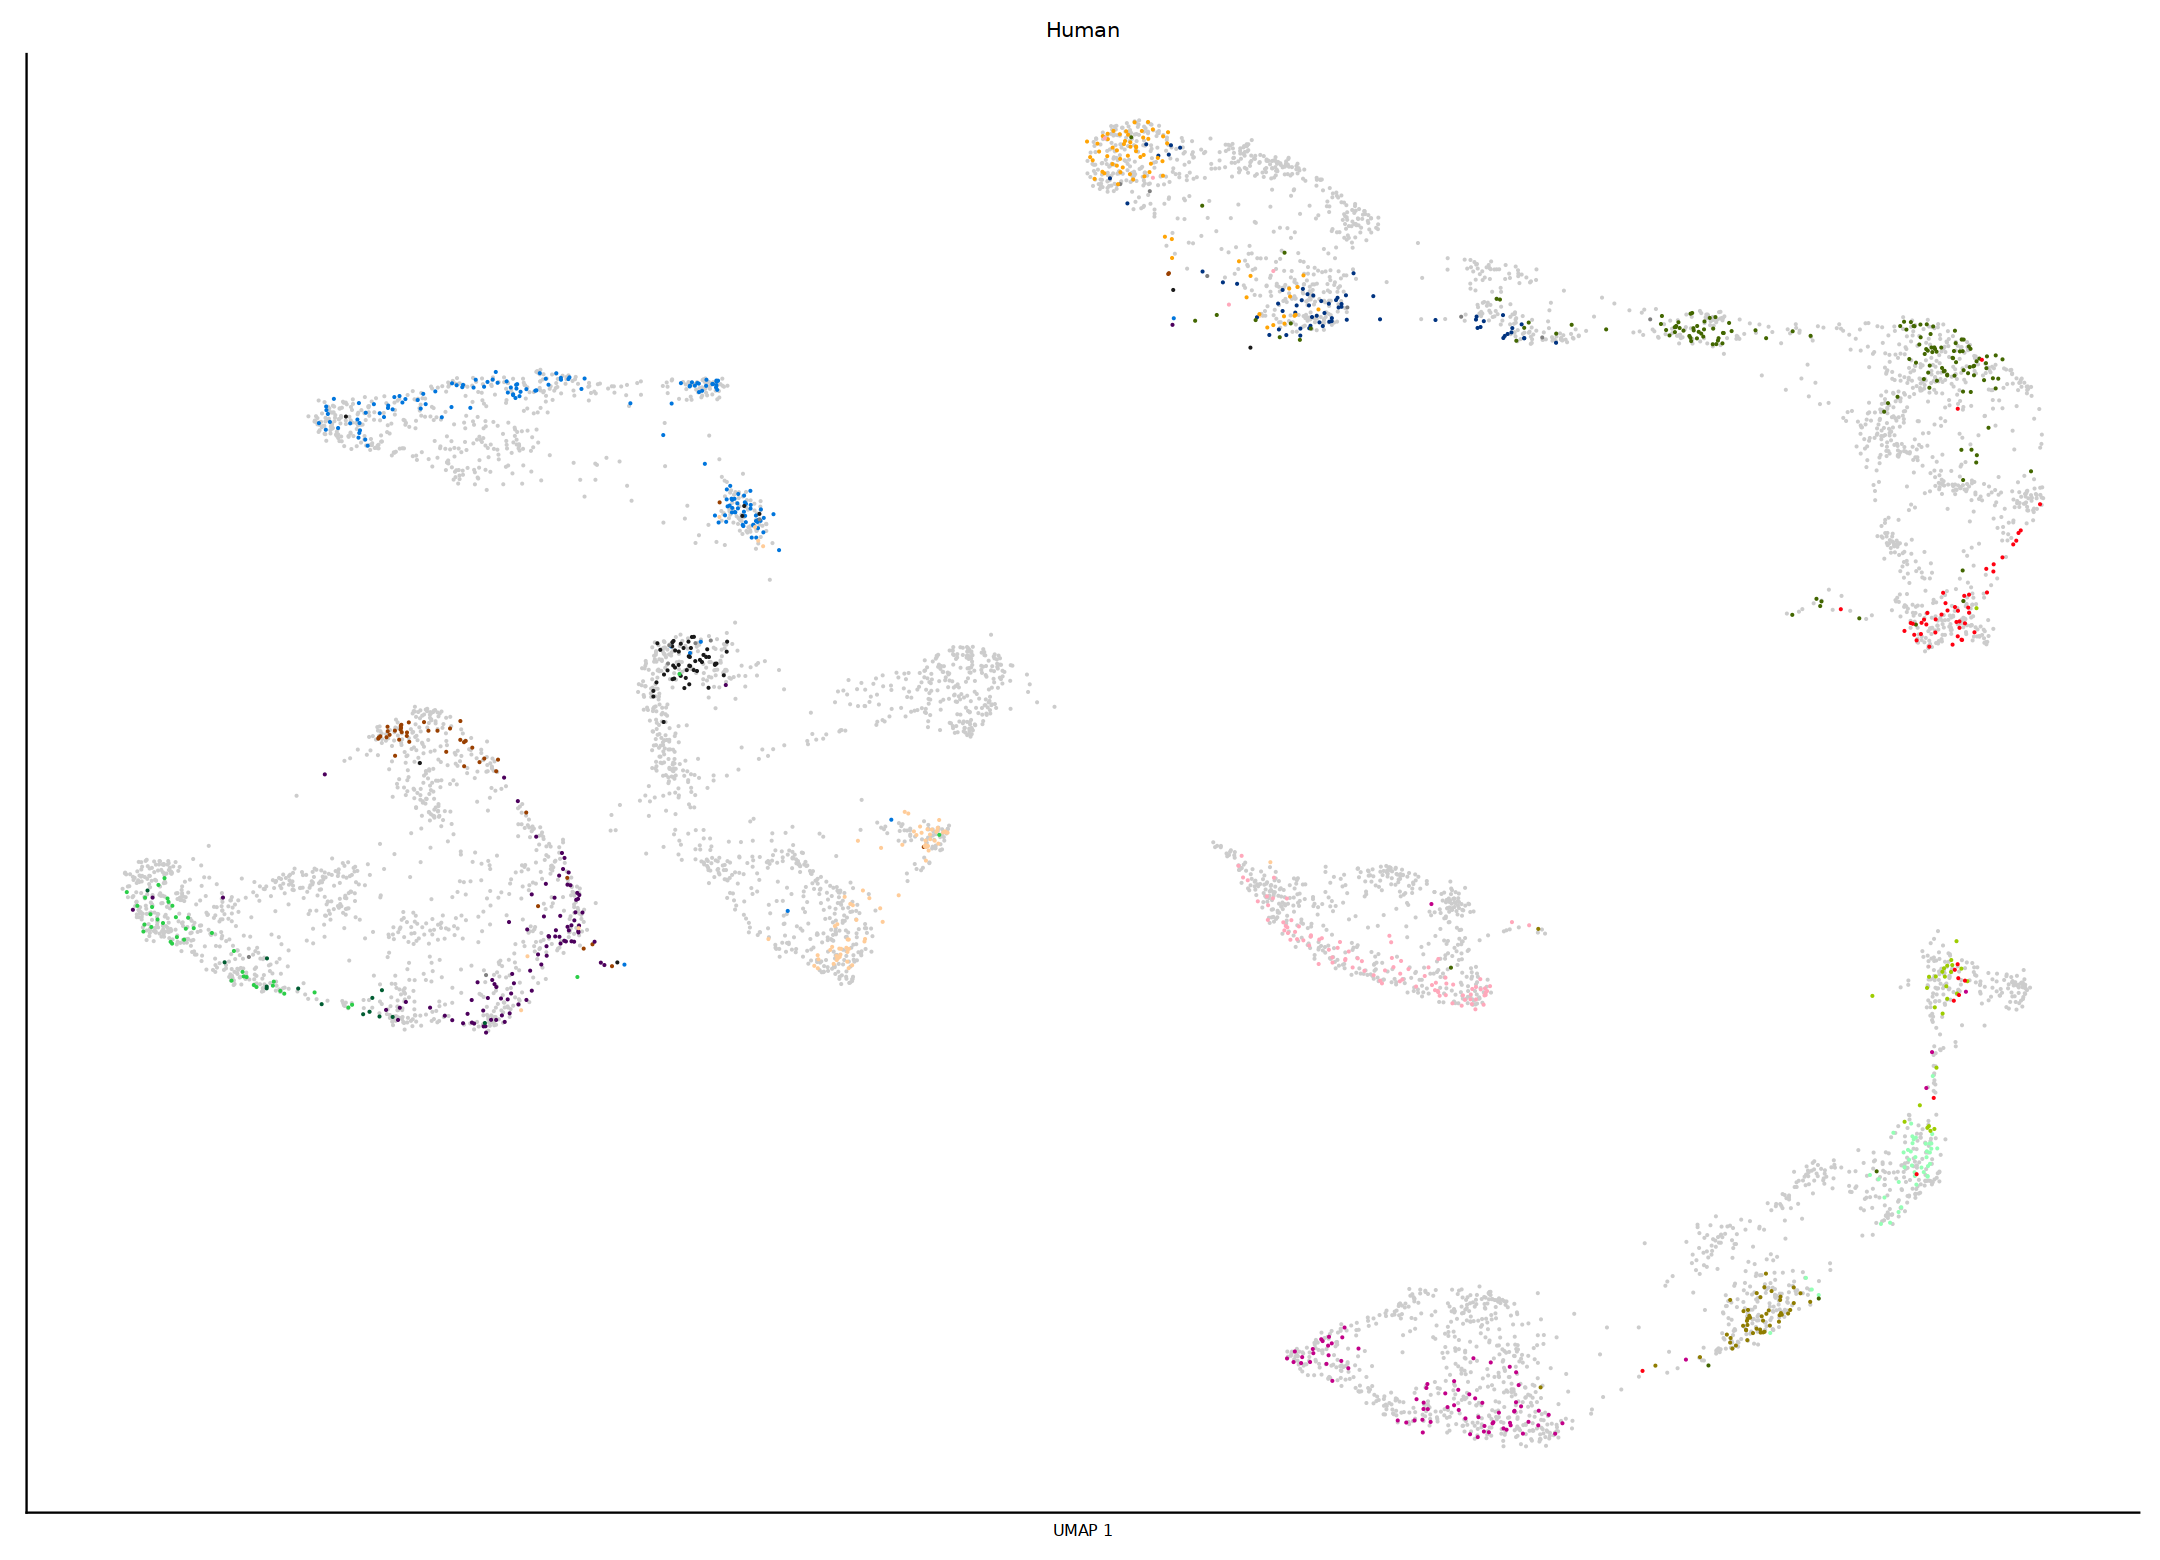

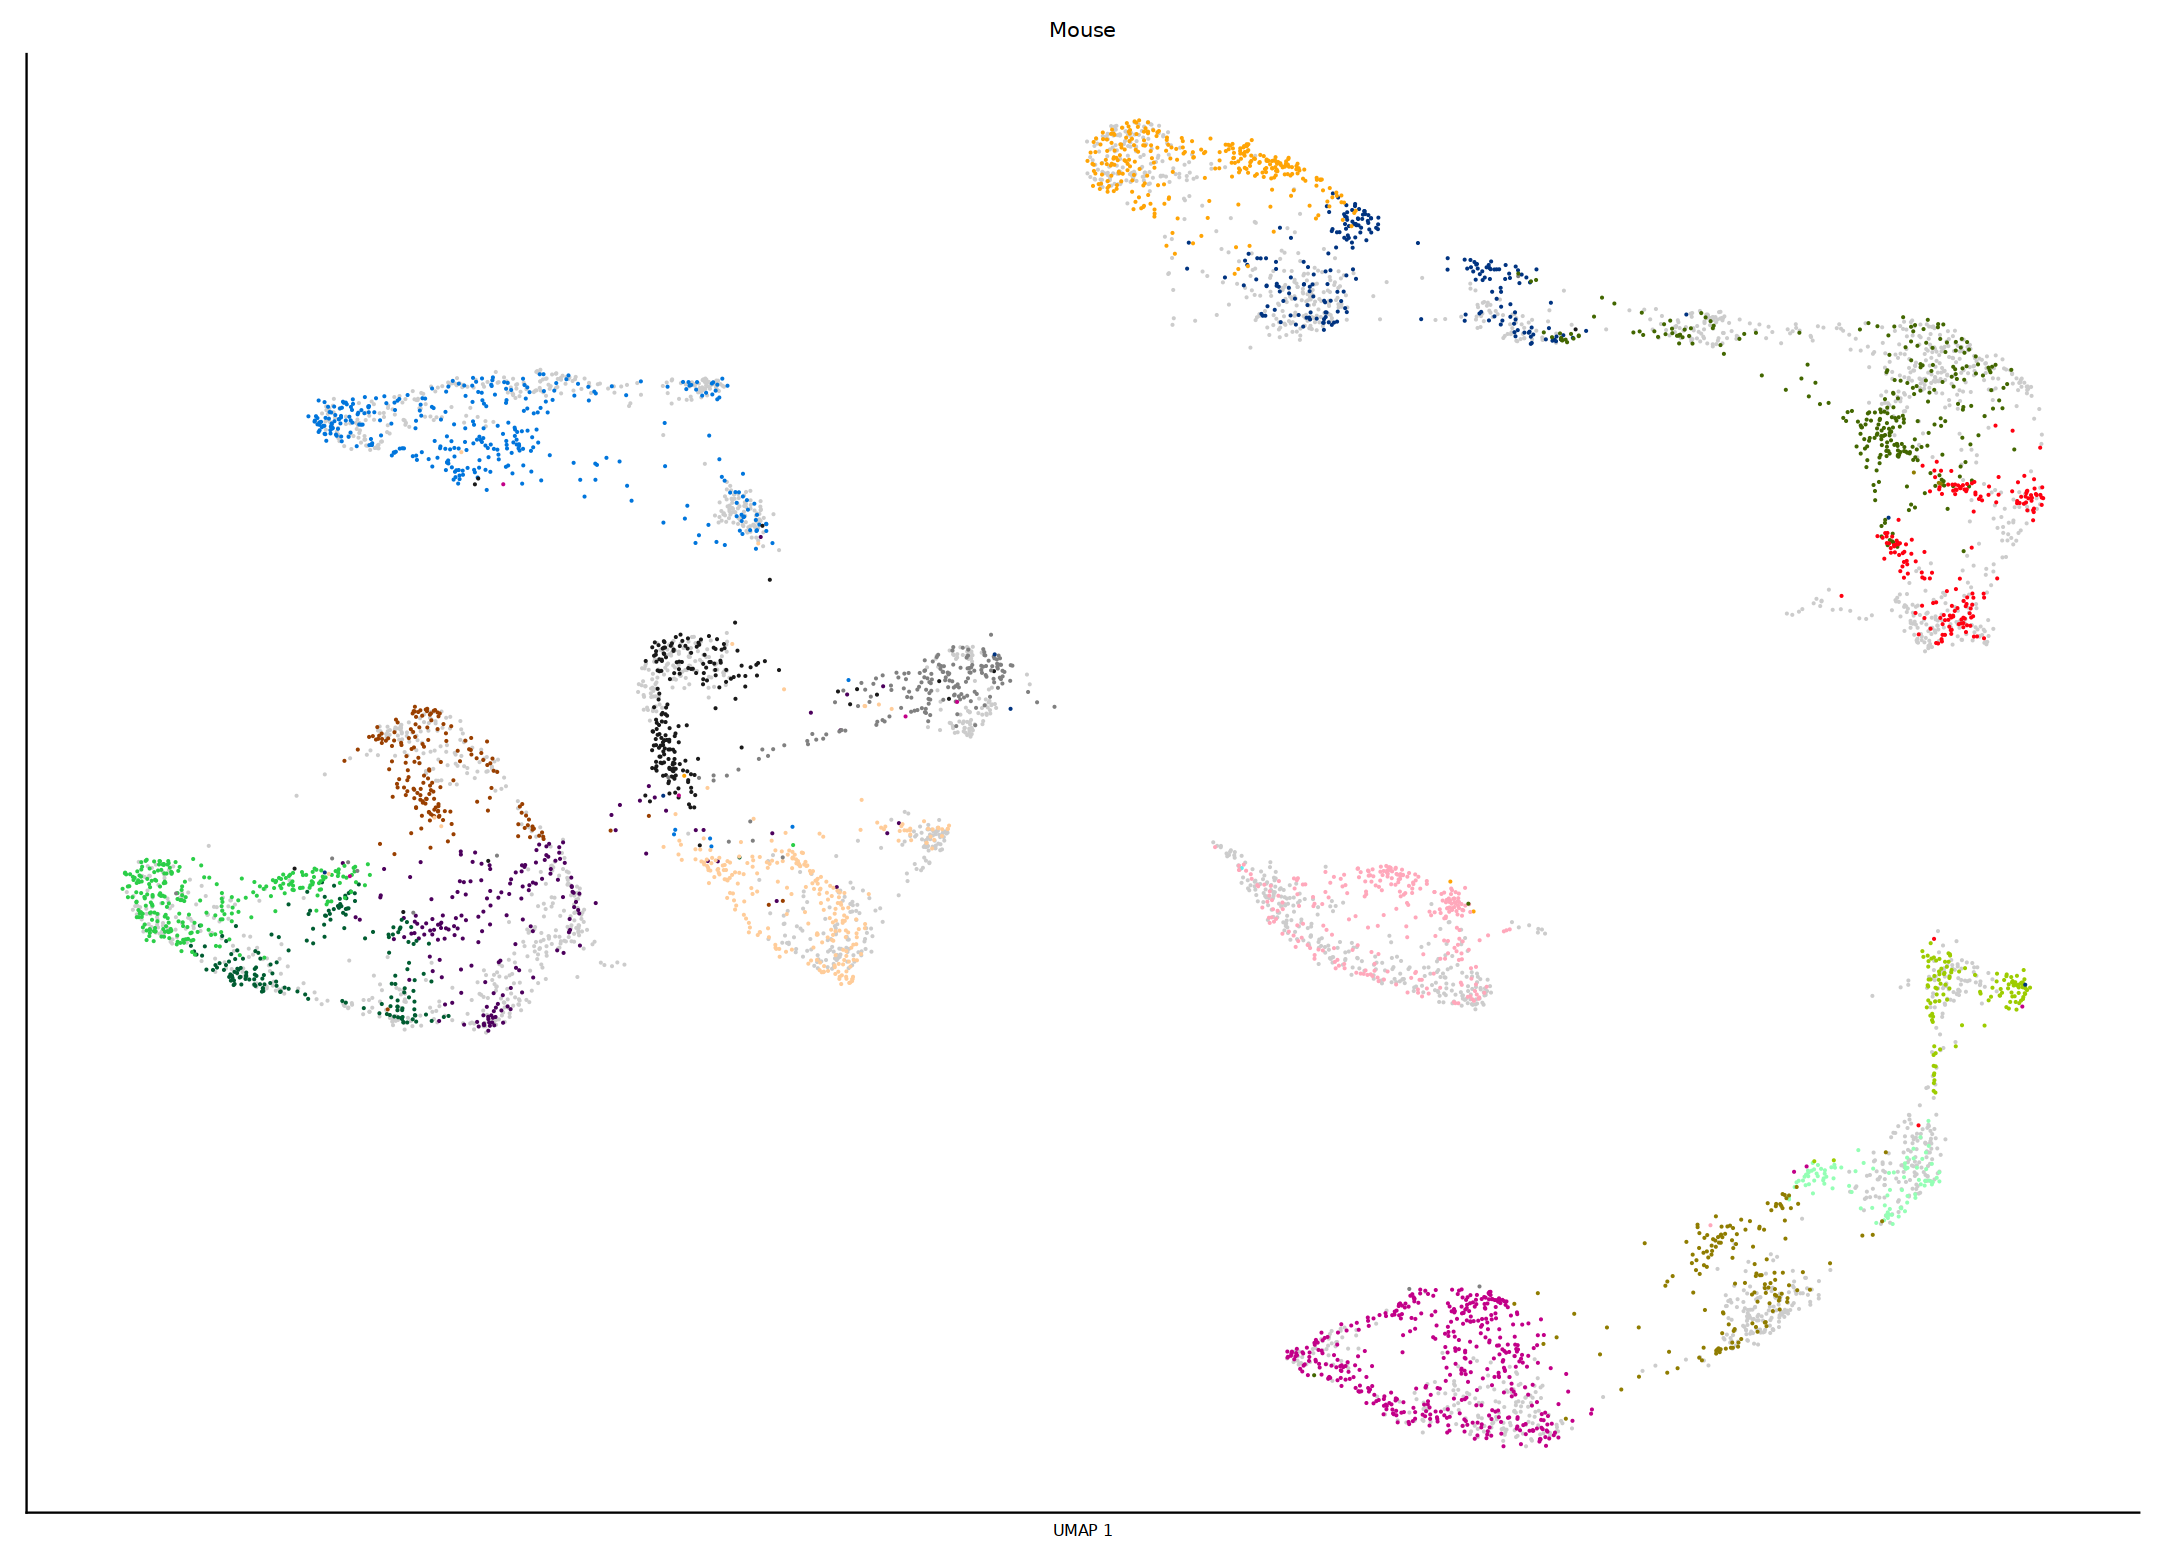

In [199]:
macaque_ordered_type_list <- macaque_ordered_types
names(macaque_ordered_type_list) = macaque_ordered_types

ident_list = c("conserved_marker_nicknames", "human_predicted_nicknames", "mouse_predicted_nicknames")
cols_list = list(cols_macaque, cols, cols_macaque)
#cols_list = list(cols_macaque, cols_macaque, cols_macaque)
title_list = c("Macaque", "Human", "Mouse")
label_yesno = c(TRUE,FALSE,FALSE)

for (ii in 1:3){
    
    Idents(object = mac_human_mouse.combined) <- ident_list[ii]
    
    p <- DimPlot(mac_human_mouse.combined, reduction = "umap", order = new_nicknames, cols = cols_list[[ii]],
              group.by = 'ident', label = label_yesno[ii], pt.size = .1,
              label.size = 1.8, repel = TRUE, na.value = "grey90", raster = FALSE) + theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_blank(),
                                                                        axis.ticks.x=element_blank(),axis.text.x=element_blank(),axis.title.x=element_text(size = 9),
                                                                        plot.title = element_text(size = 12),
                                                                         legend.position = "none") + 
                labs(title=title_list[ii], x ="UMAP 1")

    if (save_integration_figs){
        #tiff(here(paste0("figures/exploratory/arokiaraj_paper/",title_list[ii],"_integrated_",Sys.Date(),".tiff")), units="in", width=2.5, height=3, res=300)
        #png(here(paste0("figures/exploratory/arokiaraj_paper/",title_list[ii],"_integrated_",Sys.Date(),".png")), units="px", width=2.5*72, height=3*72)
        pdf(here(paste0("figures/exploratory/arokiaraj_paper/",title_list[ii],"_integrated_",Sys.Date(),".pdf")), width = 2.8, height = 3.5)
    
        print(p)
        dev.off()
        }
    
    print(p)
}


In [83]:
#options(repr.plot.width=8.5, repr.plot.height=4)
library(ggpubr)
tiff(here(paste0("figures/exploratory/arokiaraj_paper/combined_integrated_",Sys.Date(),".tiff")), units="in", width=8.5, height=5, res=300)

ggarrange(p1, p2, p3, nrow=1, common.legend = TRUE, legend="bottom") + guides(fill=guide_legend(nrow=2))
dev.off()

png 
  2

In [53]:
### silhouette scores
### based on https://github.com/satijalab/Integration2019/blob/master/analysis_code/integration/integration_metrics.R#L36
reduction <- "pca"
dims <- 1:30

dist.matrix <- dist(x = Embeddings(object = mac_human_mouse.combined[["pca"]])[, dims])
clusters <- mac_human_mouse.combined$seurat_clusters

sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
mac_human_mouse.combined$silhouette <- sil[, 3]

p <- FeaturePlot(mac_human_mouse.combined, features = "silhouette") + 
                theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_text(size = 10),
                                                   axis.ticks.x=element_blank(),axis.text.x=element_blank(),axis.title.x=element_text(size = 10),
                                                   plot.title = element_text(size = 12),
                                                   legend.position = "right") + 
                                                   labs(title="", x ="UMAP 1", y= "UMAP 2")

pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/","integrated_silouette_box",Sys.Date(),".pdf")), width = 3, height = 4.5)
bp <- boxplot(silhouette~species,data=mac_human_mouse.combined[[]], main="", xaxt='n', xlab = '', ylab="Silhouette")
tick <- seq_along(bp$names)
axis(1, at = tick, labels = FALSE)
text(tick-0.3, par("usr")[3]-.15, bp$names, srt = 45, xpd = TRUE)
dev.off()



#+ theme(axis.text.y=element_text(size = 9), axis.title.y=element_text(size = 10),
                                      #             axis.ticks.x=element_blank(),axis.text.x=element_text(size = 9),axis.title.x=element_text(size = 10),
                                      #             plot.title = element_text(size = 12),
                                      #             legend.position = "right")

if (save_integration_figs){

        pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/","integrated_silouette_umap",Sys.Date(),".pdf")), width = 4.5, height = 4)
    
        print(p)
        dev.off()
        }

# if (save_integration_figs){

#         pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/","integrated_silouette_box",Sys.Date(),".pdf")), width = 3, height = 4)
    
#         print(p2)
#         dev.off()
#         }

png 
  2

png 
  2

png 
  2

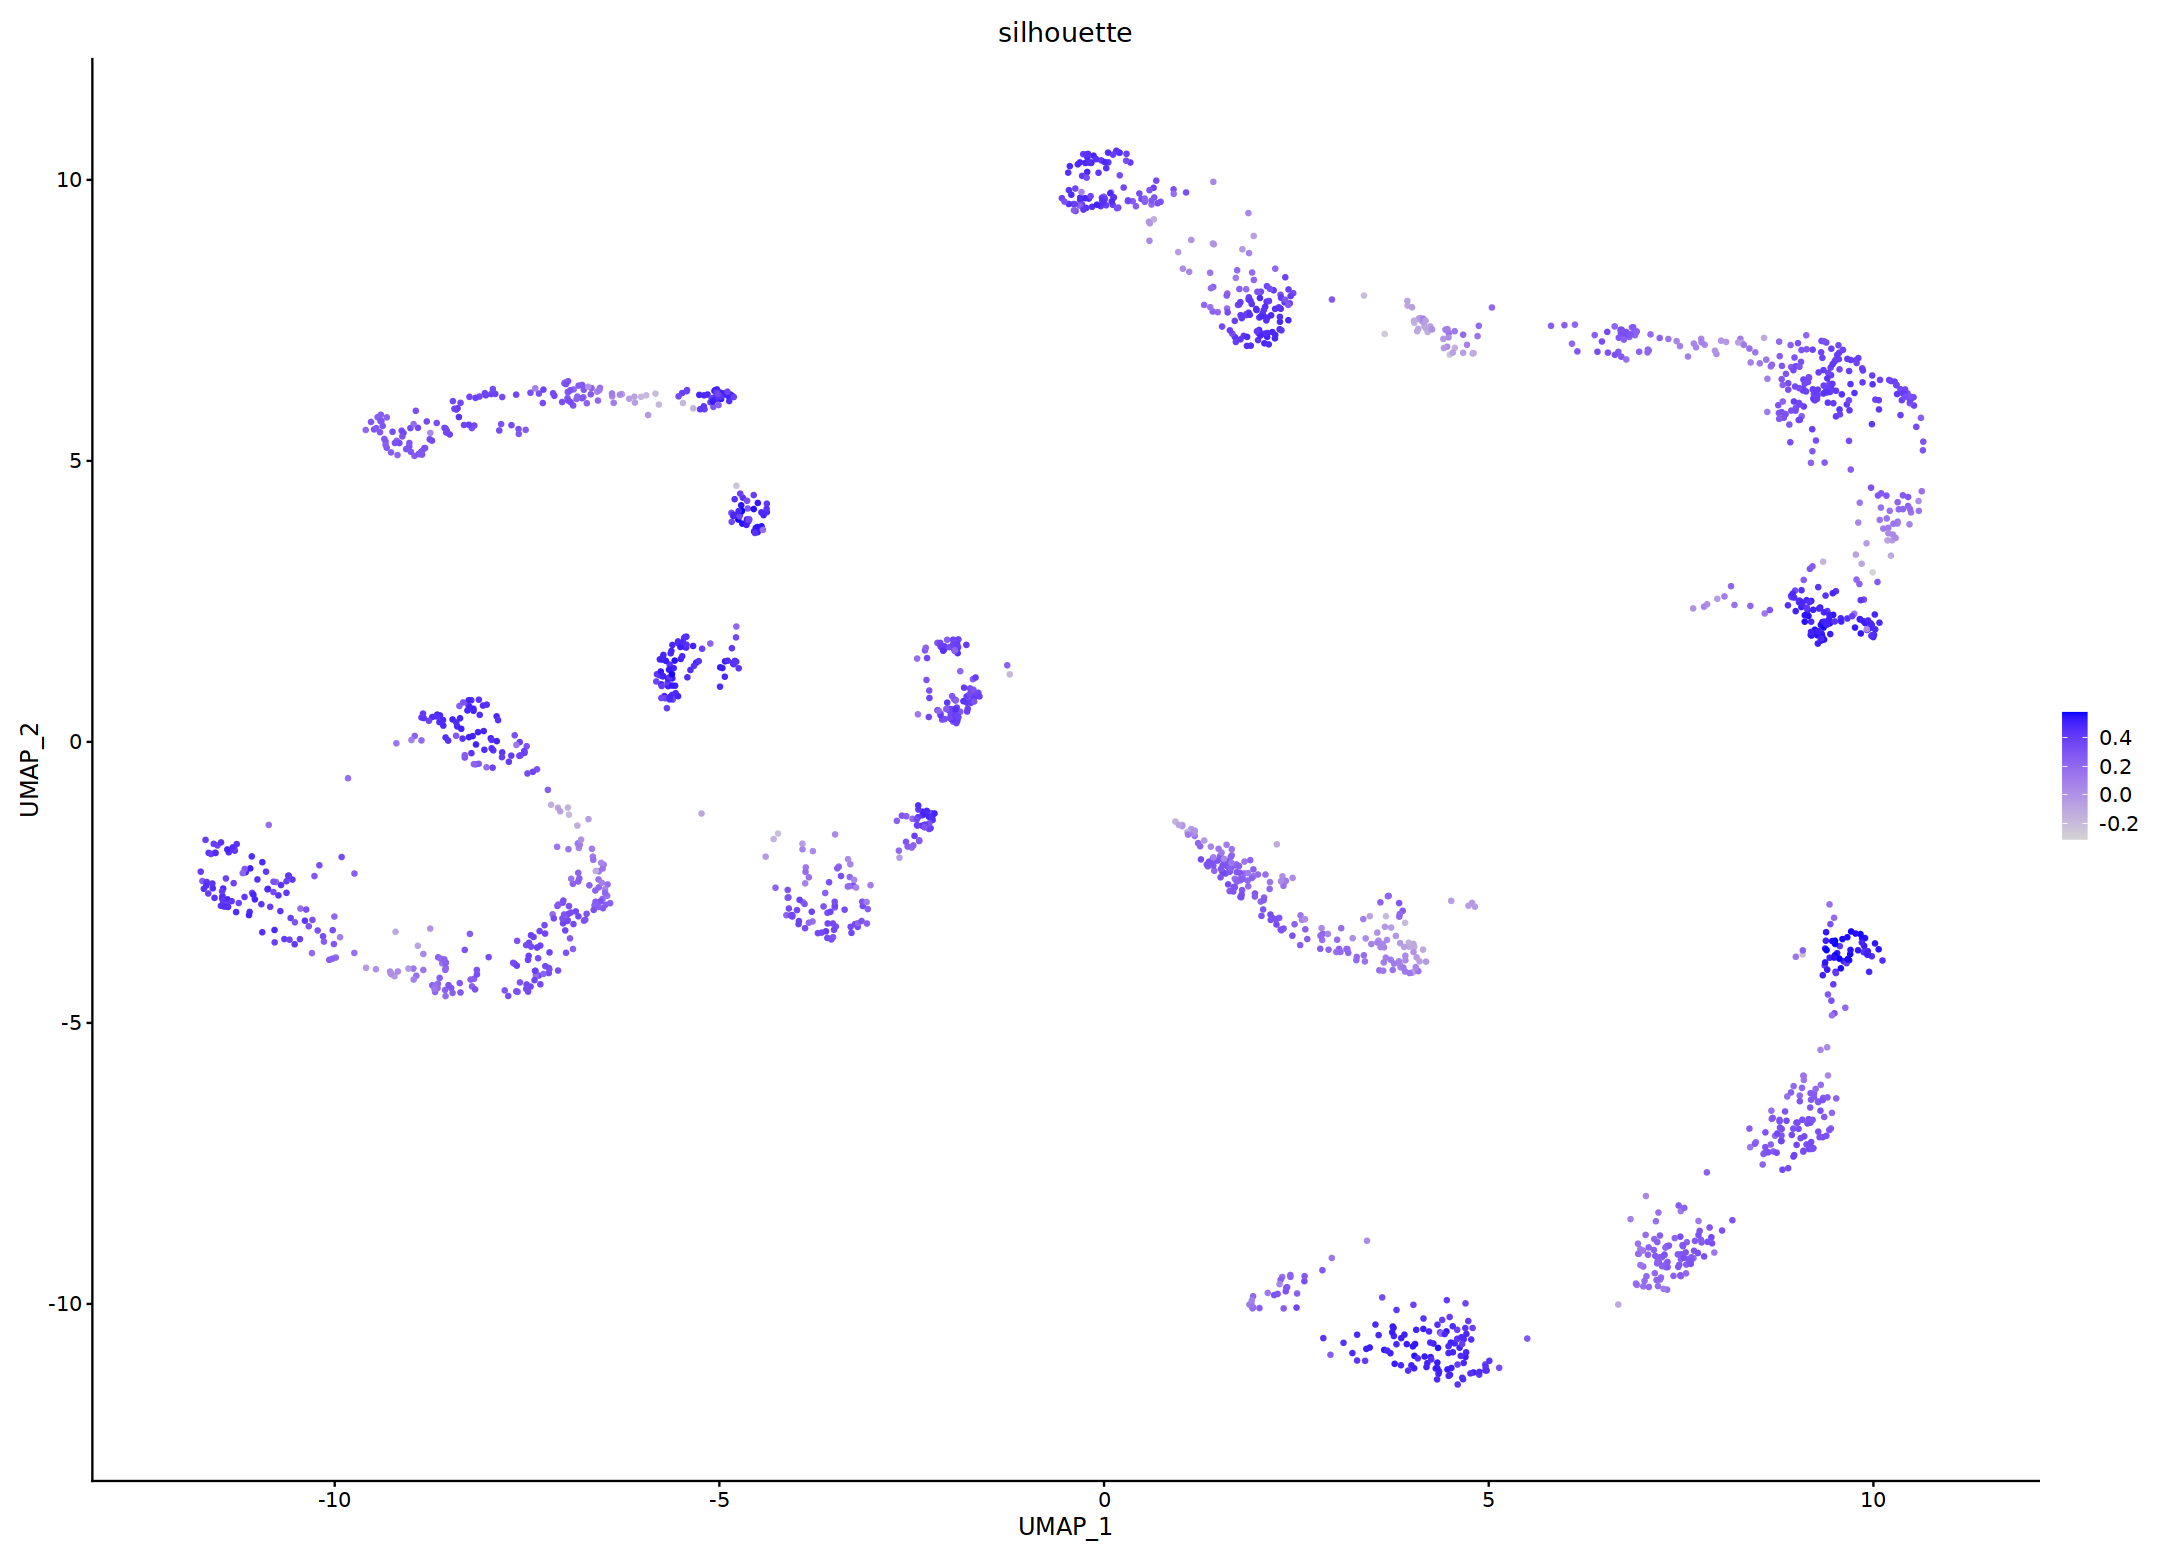

In [95]:
### macaque only silhouette -- especially looking at glut10 and glut8
macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')

reduction <- "pca"
dims <- 1:30


## give nicknames
#nicknames_to_predict = new_nicknames
#names(nicknames_to_predict) = macaque_ordered_types
macaque_subset_integrated$predicted_nicknames = nicknames_to_predict[macaque_subset_integrated$cluster_type]
macaque_subset_integrated$predicted_nicknames  <- factor(macaque_subset_integrated$predicted_nicknames , levels=new_nicknames)

dist.matrix <- dist(x = Embeddings(object = macaque_subset_integrated[["pca"]])[, dims])
clusters <- macaque_subset_integrated$seurat_clusters

sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
macaque_subset_integrated$silhouette <- sil[, 3]

FeaturePlot(macaque_subset_integrated, features = "silhouette")

macaque_subset_integrated$cluster_type <- factor(macaque_subset_integrated$cluster_type , levels=macaque_ordered_types)

pdf(here(paste0("figures/exploratory/arokiaraj_paper/integrations/","macaque_silouette_box",Sys.Date(),".pdf")), width = 7.5, height = 4.5)
bp <- boxplot(silhouette~predicted_nicknames,data=macaque_subset_integrated[[]], main="", xaxt='n', xlab = '', ylab="Silhouette", las=2)
tick <- seq_along(bp$names)
axis(1, at = tick, labels = FALSE)
y_pos = par("usr")[3] + c(-.1,-.12,-.1,-.1,-.1,-.13,-.1,-.1,-.1,-.11,-.1,-.155,-.12,-.105,-.08,-.105,-.1,-.1) - 0.05
text(tick, y_pos, bp$names, srt = 90, xpd = TRUE, cex = 0.74)
dev.off()

# Make macaque umap for Figure 1 with new conserved cell names

In [2]:
# load original macaque and show umap
macaque_rna = LoadH5Seurat("/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/macaque_integrated_neuronsv3.h5seurat",assay = "RNA")
macaque_rna$nCount_RNA = macaque_rna$nUMI # equivalent data
macaque_rna$nFeature_RNA = macaque_rna$nGene # equivalent data

macaque_cell_types = unique(macaque_rna$cluster_type)
GLUTs = macaque_cell_types[grep('GLUT', macaque_cell_types)]
GABAs = macaque_cell_types[grep('GABA', macaque_cell_types)]
macaque_dh_types = c(GLUTs, GABAs)
Idents(object = macaque_rna) <- "cluster_type"
macaque_rna_dh = subset(x = macaque_rna, idents = macaque_dh_types)
rm(macaque_rna)

Validating h5Seurat file

Initializing RNA with data

Adding counts for RNA

Adding feature-level metadata for RNA

Adding reduction pca

Adding cell embeddings for pca

Adding miscellaneous information for pca

Adding reduction scanorama

Adding cell embeddings for scanorama

Adding miscellaneous information for scanorama

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata



In [20]:
#macaque_rna_dh <- RunPCA(macaque_rna_dh, npcs = 30, verbose = FALSE)
#macaque_rna_dh <- RunUMAP(macaque_rna_dh, reduction = "pca", dims = 1:30)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:01:40 UMAP embedding parameters a = 0.9922 b = 1.112

10:01:40 Read 1954 rows and found 30 numeric columns

10:01:40 Using Annoy for neighbor search, n_neighbors = 30

10:01:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:01:41 Writing NN index file to temp file /tmp/RtmpExocSk/file691ec32678df3

10:01:41 Searching Annoy index using 28 threads, search_k = 3000

10:01:42 Annoy recall = 100%

10:01:42 Commencing smooth kNN distance calibration using 28 threads
 with target n_neighb

In [4]:
macaque_rna_dh

An object of class Seurat 
54894 features across 1954 samples within 1 assay 
Active assay: RNA (54894 features, 0 variable features)
 3 dimensional reductions calculated: pca, scanorama, umap

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


png 
  2

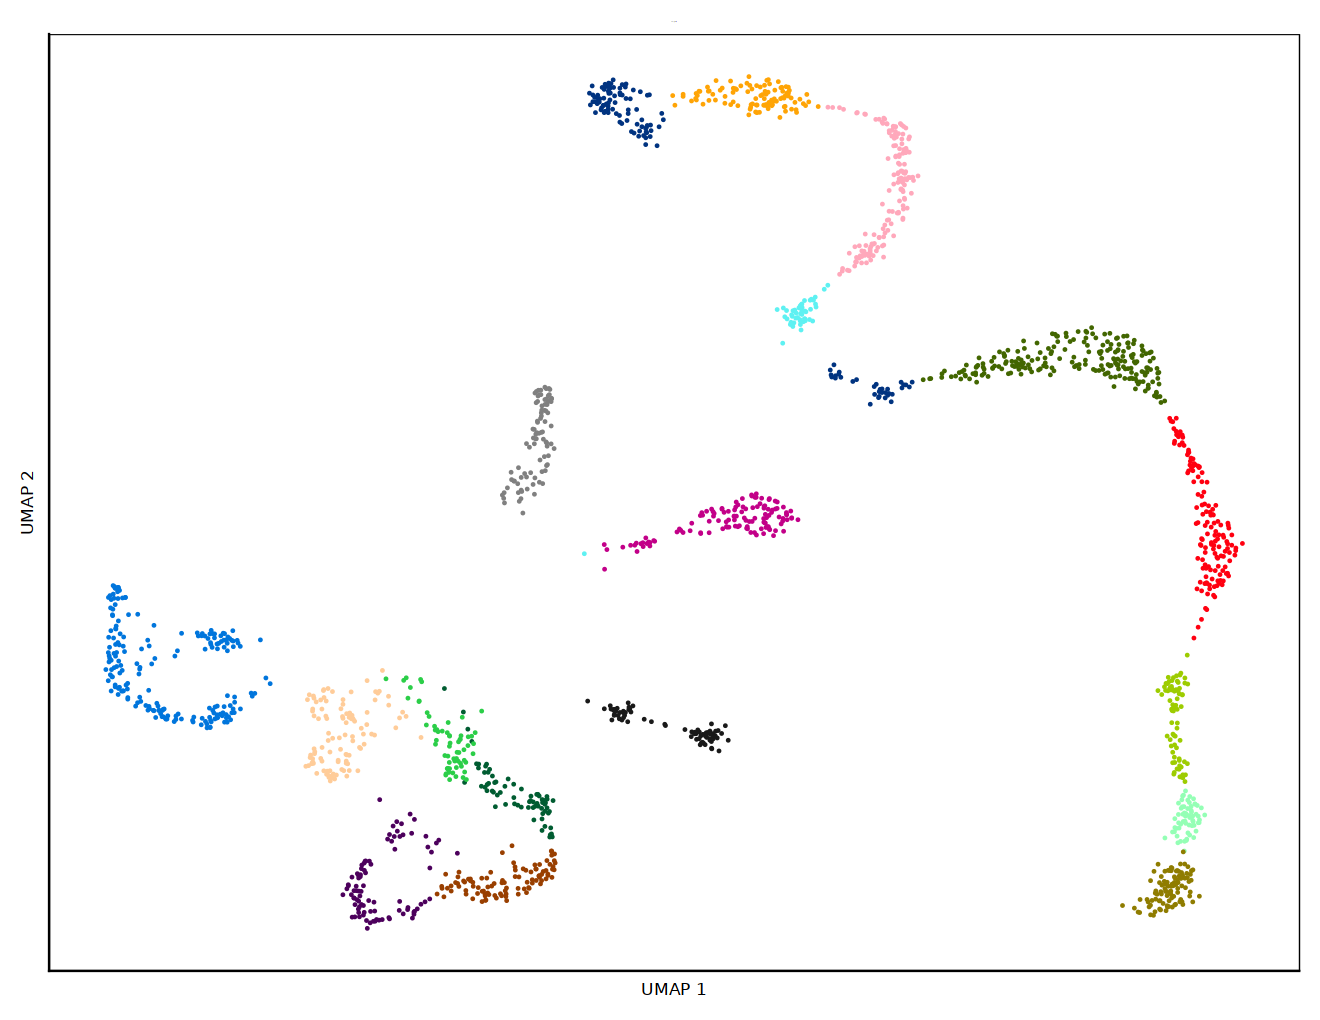

In [10]:
new_nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-NTS', 'Exc-SNTB1', 'Exc-PBX3','Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
## Try a confusion matrix
nicknames_to_predict = new_nicknames
names(nicknames_to_predict) = macaque_ordered_types
macaque_rna_dh$nicknames = nicknames_to_predict[macaque_rna_dh$cluster_type]
macaque_rna_dh$nicknames = factor(macaque_rna_dh$nicknames, levels = new_nicknames)


p2 <- DimPlot(macaque_rna_dh, reduction = "umap", 
              group.by = "nicknames", label = FALSE, pt.size= .3, cols = rev(cols_macaque),
              label.size = 2, repel = TRUE, na.value = "grey50") + theme(axis.text.y=element_blank(), axis.ticks.y=element_blank(), axis.title.y=element_text(size = 10),
                                                                        axis.ticks.x=element_blank(),axis.text.x=element_blank(),axis.title.x=element_text(size = 10),
                                                                        plot.title = element_text(size = 0),
                                                                         legend.position = "none", panel.border = element_rect(colour = "black", fill=NA, size=0.3)) +
                                                labs(x = 'UMAP 1', y = 'UMAP 2')
p2

pdf(here(paste0("figures/exploratory/arokiaraj_paper/fig1/","figure1_umap_dh",Sys.Date(),".pdf")), width = 4, height = 4)  
print(p2)
dev.off()

#macaque_subset_integrated$predicted_nicknames = nicknames_to_predict[macaque_subset_integrated$cluster_type]
#macaque_subset_integrated$predicted_nicknames  <- factor(macaque_subset_integrated$predicted_nicknames , levels=new_nicknames)

In [18]:
### get number of nuclei and number of genes per cluster
cell_frequencies = as.data.frame(table(macaque_rna_dh$nicknames))
cell_frequencies$CellType = cell_frequencies$Var1
cell_frequencies$CellType = factor(cell_frequencies$CellType, levels = new_nicknames)
cell_frequencies$CellTypeFreq = paste0(cell_frequencies$CellType,'\n',cell_frequencies$Freq)
cell_frequencies = subset(cell_frequencies, select = -c(Var1) )
cell_frequencies

# library(ggplot2)
# Basic barplot
p <-ggplot(data=cell_frequencies, aes(x=CellType, y=Freq, fill = CellType)) +
geom_bar(stat="identity") + scale_y_continuous(expand = c(0,0)) +
scale_fill_manual(values = rev( cols_macaque )    ) +
theme(axis.text.y=element_text(size = 12, colour = 'black'), axis.title.y=element_blank(), axis.title.x=element_blank(),
                                          axis.ticks.x=element_blank(),axis.text.x=element_blank(),
                                   axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1),
                                    plot.background  = element_rect(fill = "white"),
                                     panel.background = element_rect(fill = "white"),
                                     panel.grid.major = element_blank(),
                                 panel.grid.minor = element_blank(), legend.position = 'none') +
                                     labs(y = '', x = '')
pdf(here(paste0("figures/exploratory/arokiaraj_paper/fig1/","bar_nuclei_per_cluster",Sys.Date(),".pdf")), width = 3.5, height = 3)
     print(p)
     dev.off()

Freq CellType     CellTypeFreq     
1  142  Exc-BNC2     Exc-BNC2\n142    
2  222  Exc-NMUR2    Exc-NMUR2\n222   
3  152  Exc-NMU      Exc-NMU\n152     
4   49  Exc-TAC3     Exc-TAC3\n49     
5  105  Exc-LMO3     Exc-LMO3\n105    
6  123  Exc-SKOR2    Exc-SKOR2\n123   
7  124  Exc-MAF      Exc-MAF\n124     
8   76  Exc-MAFA     Exc-MAFA\n76     
9   98  Exc-NTS      Exc-NTS\n98      
10  62  Exc-SNTB1    Exc-SNTB1\n62    
11  89  Exc-PBX3     Exc-PBX3\n89     
12 109  Inh-CACNA2D3 Inh-CACNA2D3\n109
13  65  Inh-SORCS1   Inh-SORCS1\n65   
14  71  Inh-PDZD2    Inh-PDZD2\n71    
15  74  Inh-NPY      Inh-NPY\n74      
16  91  Inh-MEF2C    Inh-MEF2C\n91    
17 100  Inh-NXPH1    Inh-NXPH1\n100   
18 202  Inh-PDYN     Inh-PDYN\n202

png 
  2

In [15]:
### nUMI and nGenes
p <- VlnPlot(macaque_rna_dh, group.by = 'nicknames', features = 'nUMI', cols = rev(cols_macaque), pt.size = 0) + ylim(0,40000) +
theme(axis.text.y=element_text(size = 11), axis.title.y=element_text(size = 10), axis.title.x=element_text(size = 10),
                                          axis.ticks.x=element_blank(),axis.text.x=element_text(size = 10,angle = 90, vjust = 0.5, hjust=1),
                                   axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1),
                                    plot.background  = element_rect(fill = "white"),
                                     panel.background = element_rect(fill = "white"),
                                     panel.grid.major = element_blank(),
                                 panel.grid.minor = element_blank(), legend.position = 'none') +
                                     labs(title = '', y = 'Unique RNA molecules', x = '')
p2 <- VlnPlot(macaque_rna_dh, group.by = 'nicknames', features = 'nGene', cols = rev(cols_macaque), pt.size = 0) +
theme(axis.text.y=element_text(size = 11), axis.title.y=element_text(size = 10), axis.title.x=element_blank(),
                                          axis.ticks.x=element_blank(),axis.text.x=element_blank(),
                                   axis.line.x = element_line(color="black", size = 1), axis.line.y = element_line(color="black", size = 1),
                                    plot.background  = element_rect(fill = "white"),
                                     panel.background = element_rect(fill = "white"),
                                     panel.grid.major = element_blank(),
                                 panel.grid.minor = element_blank(), legend.position = 'none') +
                                     labs(title = '', y = 'Unique Genes', x = '')

pdf(here(paste0("figures/exploratory/arokiaraj_paper/fig1/","nUMI",Sys.Date(),".pdf")), width = 3.5, height = 4)
     print(p)
     dev.off()
pdf(here(paste0("figures/exploratory/arokiaraj_paper/fig1/","nGenes",Sys.Date(),".pdf")), width = 3.5, height = 3)
     print(p2)
     dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 3 rows containing non-finite values (`stat_ydensity()`).”


png 
  2

png 
  2

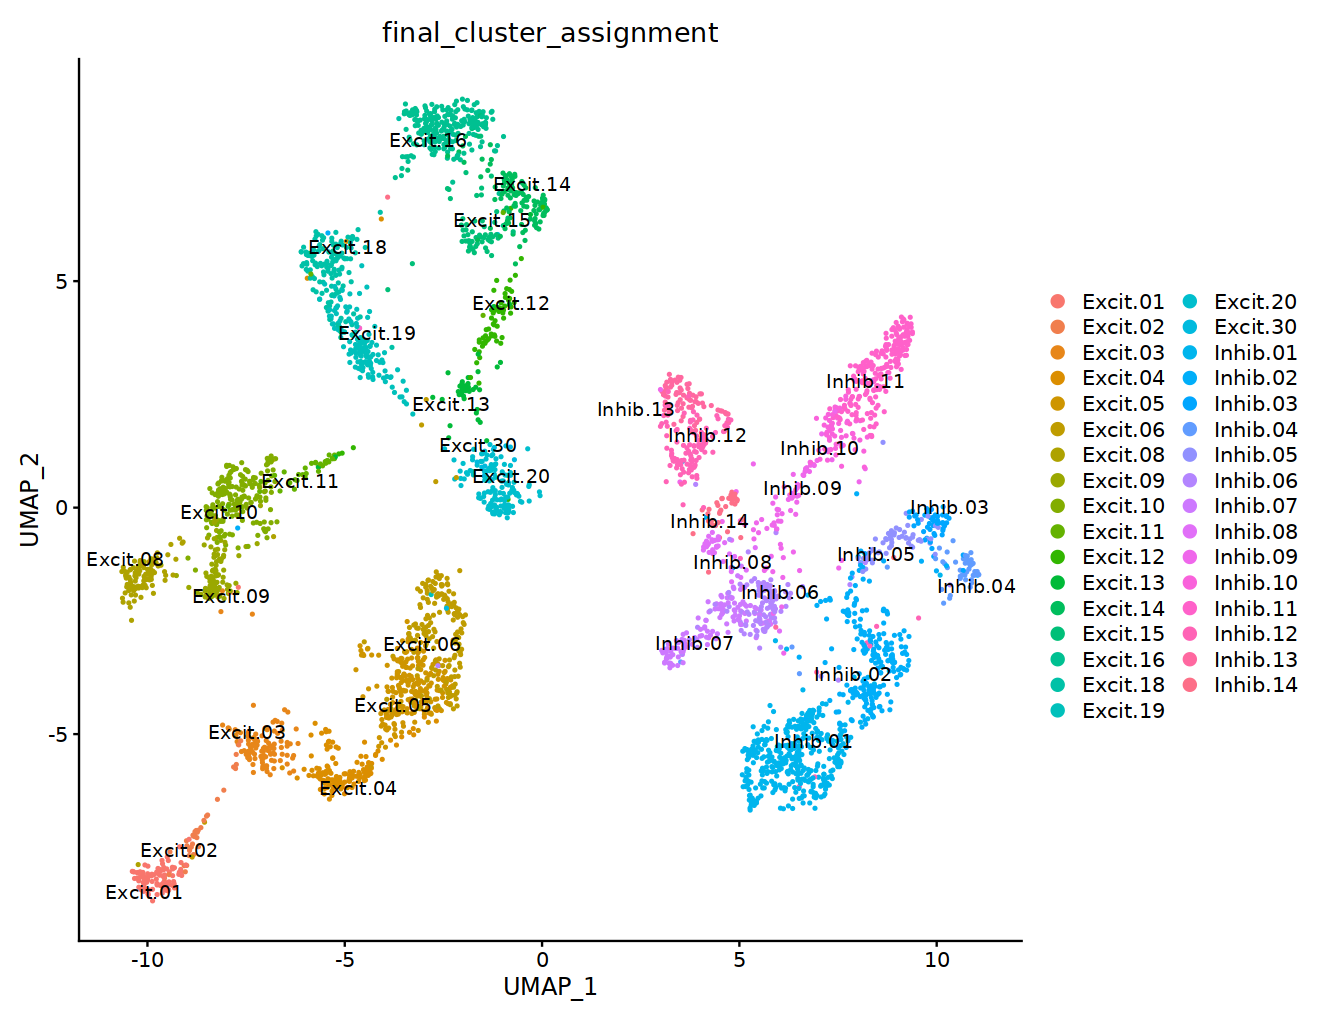

In [27]:
p2 <- DimPlot(mouse_rna, reduction = "umap", 
              group.by = "final_cluster_assignment", label = TRUE, 
              label.size = 4, repel = TRUE, na.value = "grey50")
p2

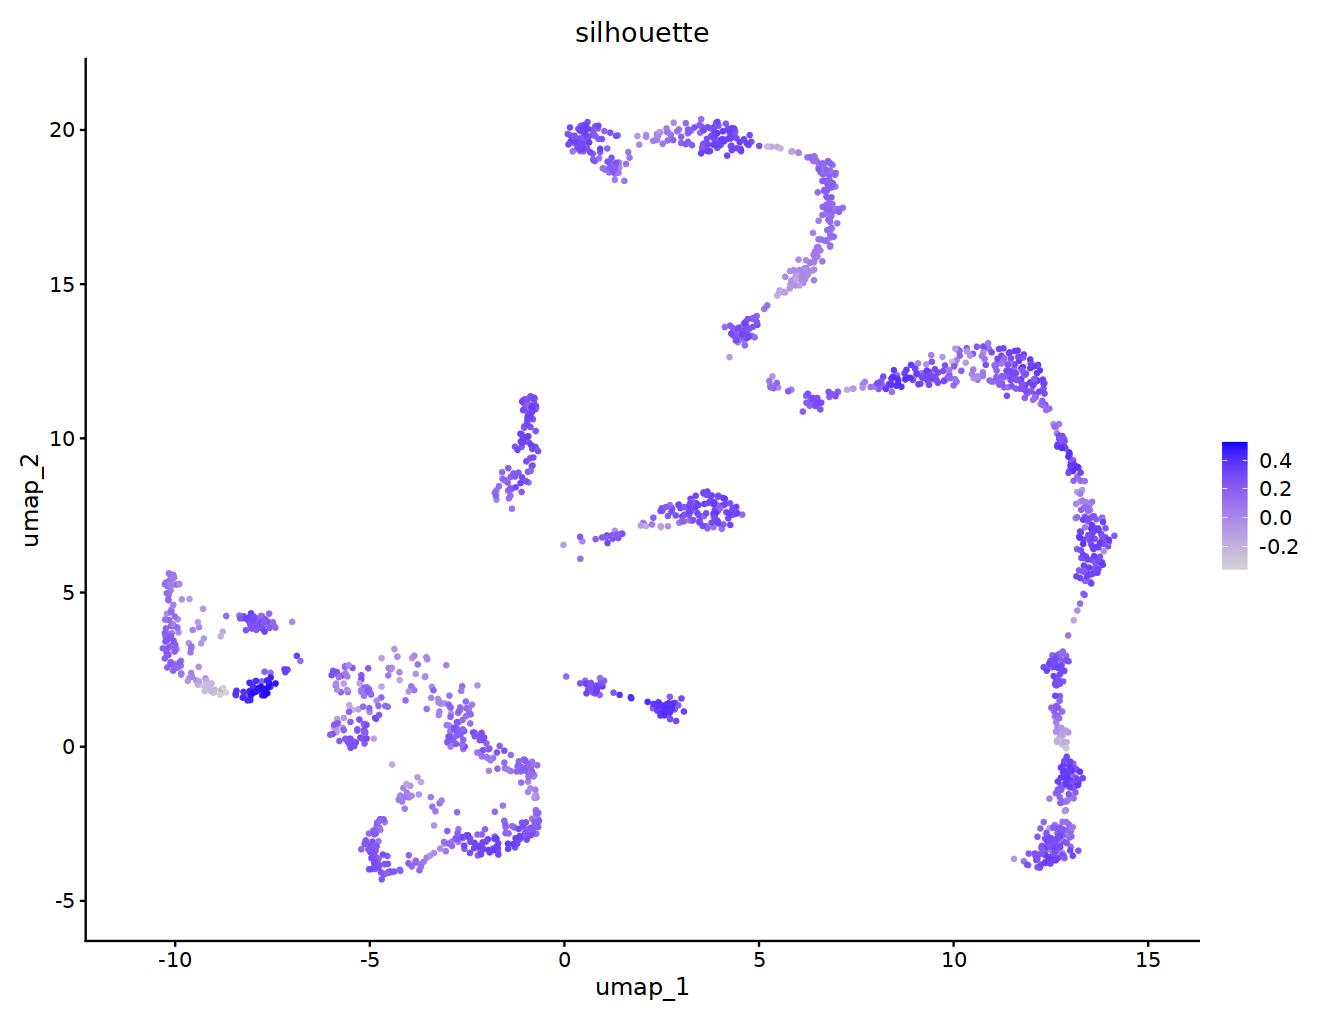

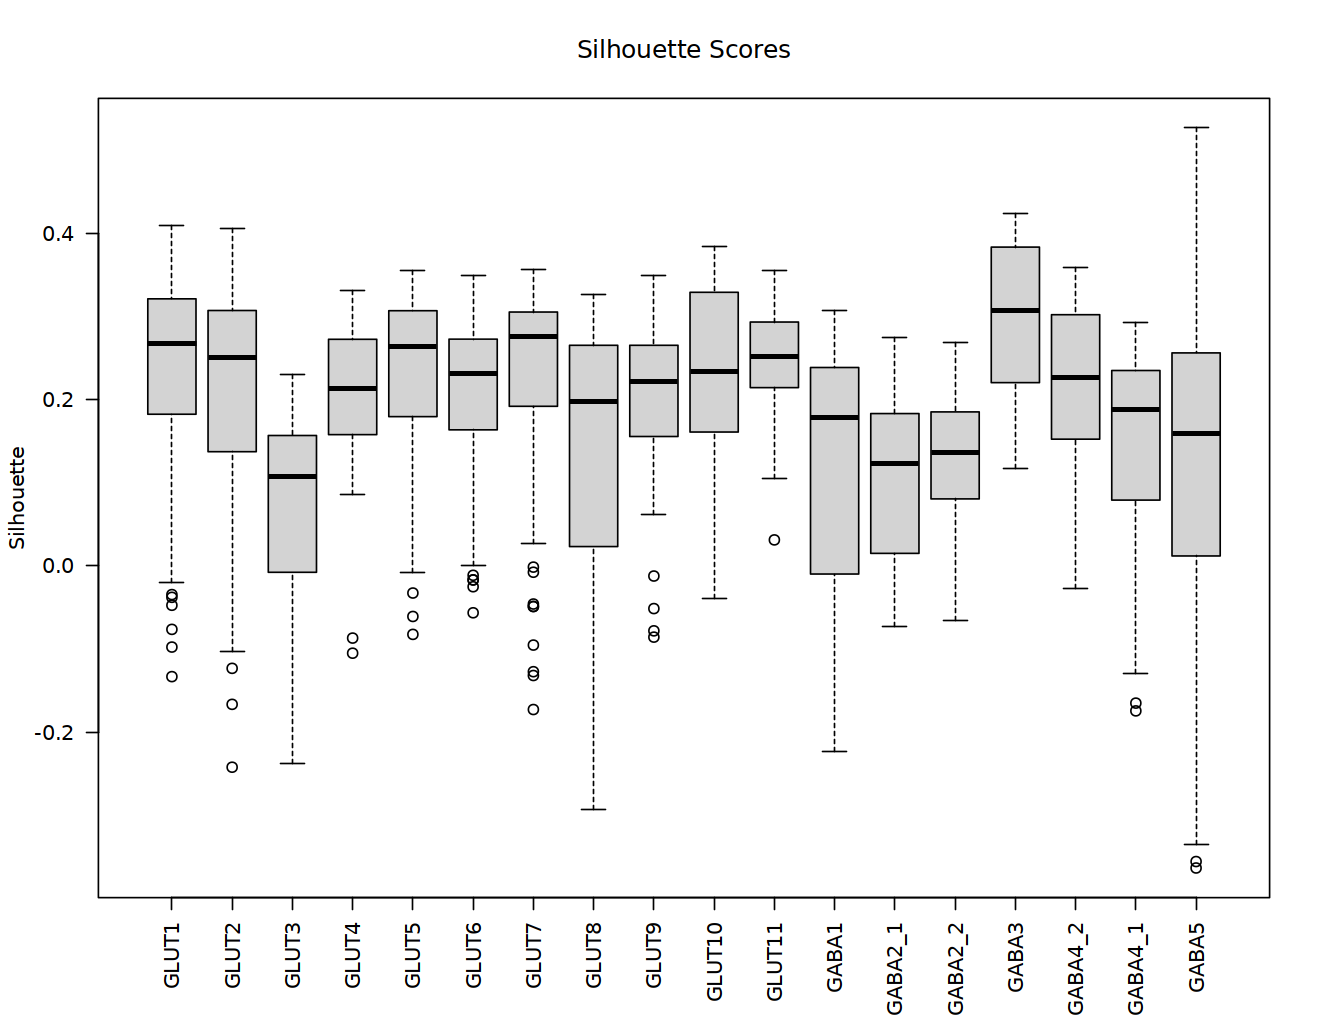

In [38]:
### macaque only silhouette and macaque only data -- especially looking at glut10 and glut8
macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')

reduction <- "pca"
dims <- 1:30

dist.matrix <- dist(x = Embeddings(object = macaque_rna_dh[["pca"]])[, dims])
clusters <- macaque_rna_dh$clust_2

sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
macaque_rna_dh$silhouette <- sil[, 3]

FeaturePlot(macaque_rna_dh, features = "silhouette")

macaque_rna_dh$cluster_type <- factor(macaque_rna_dh$cluster_type , levels=macaque_ordered_types)
boxplot(silhouette~cluster_type,data=macaque_rna_dh[[]], main="Silhouette Scores",
   xlab = '', ylab="Silhouette", las=2)

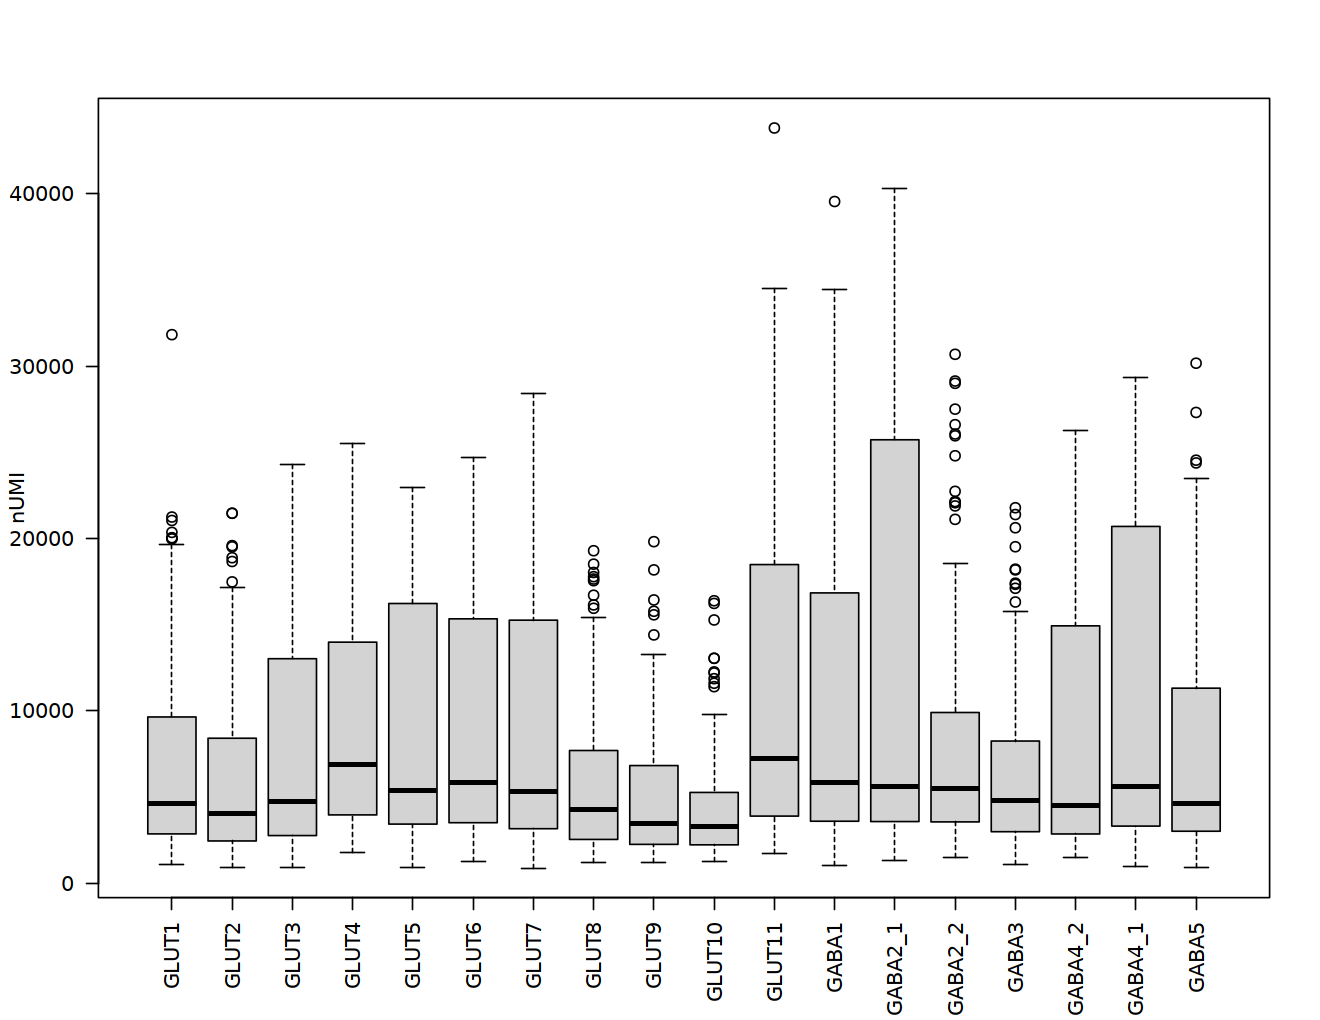

In [36]:
boxplot(nUMI~cluster_type,data=macaque_rna_dh[[]], main="",
   xlab = '', ylab="nUMI", las=2)

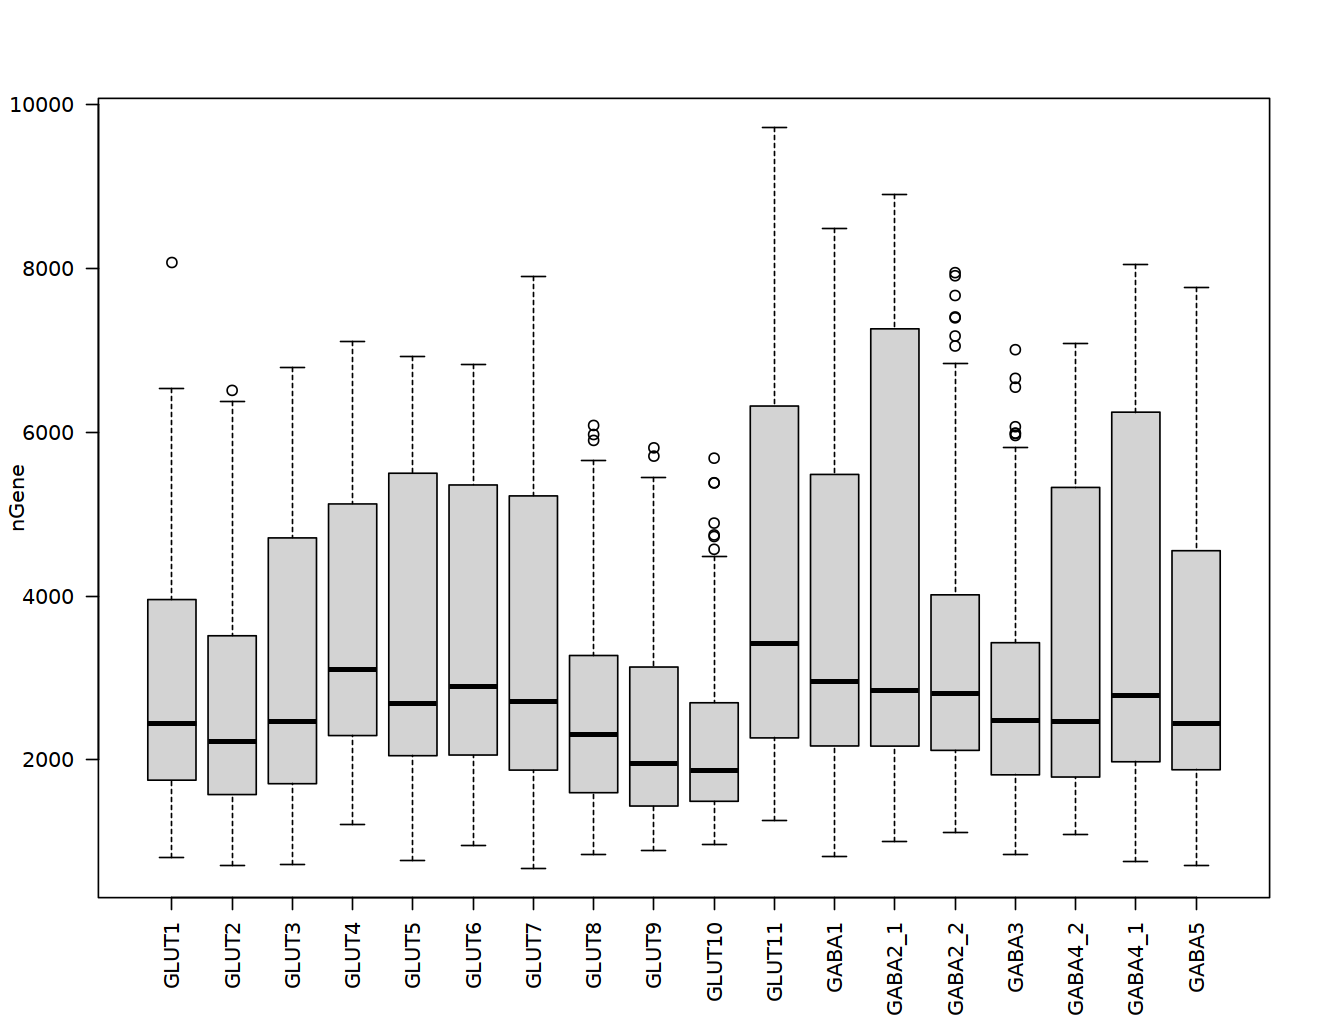

In [37]:
boxplot(nGene~cluster_type,data=macaque_rna_dh[[]], main="",
   xlab = '', ylab="nGene", las=2)